<a href="https://colab.research.google.com/github/fshnkarimi/Labeling/blob/Afshin/Buy%26Hold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Implement Buy&Hold strategy
def buy_and_sell(df, InitialCapital):
    '''
    Update capital and number of shares after each buy or sell based on labels.

    Parameters
    ----------
        df : dataframe
            target dataframe for using buh&hold strategy
        InitialCapital : int
            Amount of initial capital
        
    Returns
    -------
    dataframe
        modified dataframe after implementing buy&hold strategy on input dataframe
    """
    '''
    capital = InitialCapital
    stock = 0
    old_trend = new_trend = df.Label[0]
    final_capitals = []
    last_index = df.loc[df.Label == 0, :].tail(1).index
    for i in range(df.Label.count()):
        new_trend = df.Label[i]
        
        if new_trend == 1 and capital != 0 and df.index[i] <= last_index:
          # Buy
          stock = capital / df.Price[i]
          capital = 0
          df['Trade Signal'][i] = 'Buy'
          df['Number of Shares'][i] = "{0:0.2f}".format(stock)

        elif new_trend != old_trend and new_trend == 0:
            # sell
            if stock != 0:
                capital = stock * df.Price[i]
                stock = 0
                df['Trade Signal'][i] = 'Sell'
                df['Number of Shares'][i] = '0'
        else:
            if i != 0:
                df['Number of Shares'][i] = df['Number of Shares'][i-1] 

        if capital != 0:
            final_capitals.append(capital)
        else:
            final_capitals.append(stock * df.Price[i])

        old_trend = df.Label[i]
    
    df = df.assign(FinalCapital=pd.Series(final_capitals))
    return df

In [3]:
# Calculate rate of return
def ROR(df, InitialCapital):
    '''
    Calculate rate of return for each row that we have stock

    Parameters
    ----------
        df : dataframe
            dataframe for calculating ror
        InitialCapital : int
            Amount of initial capital
        
    Returns
    -------
    dataframe
        modified dataframe after updating ROR values
    """
    '''

    df = df.assign(ROR=pd.Series(df.FinalCapital - InitialCapital)/ InitialCapital * 100)

    return df

In [4]:
def DD(df):
    pct = df[["Price"]].pct_change()
    wealth_index = InitialCapital * (1 + pct["Price"]).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdown = (wealth_index - previous_peaks) / previous_peaks
    drawdown = list(abs(drawdown))
    drawdown[0] = 0
    df = df.assign(DD=pd.Series(drawdown))
    return df

In [5]:
# Sharpe Ratio
# This should be changed
def sharpe_ratio(df):
    R = df.ROR[-1:].values[0]
    sr = R / df.ROR.std()
    return sr

In [6]:
def metrics(df, InitialCapital):
    df = buy_and_sell(df, InitialCapital)
    df = ROR(df, InitialCapital)
    df = DD(df)
    MDD = max(abs(df.DD))
    # Add RRR column
    df['RRR'] = (df['ROR'] / MDD) * 100

    sr = sharpe_ratio(df)
    print(f"Sharpe Ratio = {sr} \n")
    print(f"MDD = {MDD} \n")
    return df

In [7]:
InitialCapital = 10e6
InitialCapital

10000000.0

In [8]:
# This function will be added to the main code

# def modify_df(df, dataset_type):
#     date_col = 'DATE'
#     close_col = 'closingprice'
#     if dataset_type == 'crypto':
#         date_col = 'Date'
#         close_col = 'Price'
#     data = {'Date': df[date_col], 'Price': df[close_col],
#         'Label': df['labels'], 'Trade Signal': '', 'Number of Shares': '0'}
#     df_new = pd.DataFrame(data)
#     return df_new

In [14]:
# This function will be uncomment after updating the main code

# def add_metrics(df, file_name):
#     metrics_ = metrics(df, InitialCapital)
#     file_name = file_name + '_metrics.csv'
#     metrics_.to_csv(file_name)
#     print(metrics_.tail())

def add_metrics(df, file_name, dataset_type = 'china'):
    date_col = 'DATE'
    close_col = 'closingprice'
    if dataset_type == 'crypto':
        date_col = 'Date'
        close_col = 'Price'
    elif dataset_type == 'sp':
        date_col = '<DATE>'
        close_col = '<CLOSE>'
    data = {'Date': df[date_col], 'Price': df[close_col],
        'Label': df['labels'], 'Trade Signal': '', 'Number of Shares': '0'}
    df_new = pd.DataFrame(data)

    metrics_ = metrics(df_new, InitialCapital)
    file_name = file_name + '_metrics.csv'
    metrics_.to_csv(file_name)
    print(metrics_.tail())
    return metrics_

# BTC

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('btc_lstm.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm', dataset_type='crypto')

Sharpe Ratio = 1.2083079648278074 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  10.163207  0.060956  1906.962315
286  Oct 13, 2020  11423.8      0  ...  10.163207  0.069920  1906.962315
287  Oct 14, 2020  11420.4      0  ...  10.163207  0.070197  1906.962315
288  Oct 15, 2020  11503.0      0  ...  10.163207  0.063472  1906.962315
289  Oct 16, 2020  11322.0      1  ...  10.163207  0.078208  1906.962315

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,Buy,1435.34,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,,1435.34,1.053983e+07,5.398306,0.000000,1012.905375
3,"Jan 04, 2020",7376.8,1,,1435.34,1.058820e+07,5.882015,0.000000,1103.665575
4,"Jan 05, 2020",7372.5,1,,1435.34,1.058203e+07,5.820296,0.000583,1092.084897
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.101632e+07,10.163207,0.060956,1906.962315
286,"Oct 13, 2020",11423.8,0,,0,1.101632e+07,10.163207,0.069920,1906.962315
287,"Oct 14, 2020",11420.4,0,,0,1.101632e+07,10.163207,0.070197,1906.962315
288,"Oct 15, 2020",11503.0,0,,0,1.101632e+07,10.163207,0.063472,1906.962315


In [ ]:
# Purge
df = pd.read_csv('btc_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm_p', dataset_type='crypto')

Sharpe Ratio = 0.3025624073108589 

MDD = 0.5329526758927707 

             Date    Price  Label  ...      ROR        DD         RRR
285  Oct 12, 2020  11533.9      0  ...  2.65455  0.060956  498.083554
286  Oct 13, 2020  11423.8      0  ...  2.65455  0.069920  498.083554
287  Oct 14, 2020  11420.4      0  ...  2.65455  0.070197  498.083554
288  Oct 15, 2020  11503.0      0  ...  2.65455  0.063472  498.083554
289  Oct 16, 2020  11322.0      1  ...  2.65455  0.078208  498.083554

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,,1388.93,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,,1388.93,1.019903e+07,1.990333,0.000000,373.453996
3,"Jan 04, 2020",7376.8,1,,1388.93,1.024584e+07,2.458402,0.000000,461.279534
4,"Jan 05, 2020",7372.5,1,,1388.93,1.023987e+07,2.398678,0.000583,450.073308
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.026545e+07,2.654550,0.060956,498.083554
286,"Oct 13, 2020",11423.8,0,,0,1.026545e+07,2.654550,0.069920,498.083554
287,"Oct 14, 2020",11420.4,0,,0,1.026545e+07,2.654550,0.070197,498.083554
288,"Oct 15, 2020",11503.0,0,,0,1.026545e+07,2.654550,0.063472,498.083554


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('btc_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm_beta', dataset_type='crypto')

Sharpe Ratio = 1.8991965111347162 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  23.986295  0.060956  4500.642535
286  Oct 13, 2020  11423.8      0  ...  23.986295  0.069920  4500.642535
287  Oct 14, 2020  11420.4      1  ...  23.986295  0.070197  4500.642535
288  Oct 15, 2020  11503.0      0  ...  24.883047  0.063472  4668.903652
289  Oct 16, 2020  11322.0      1  ...  24.883047  0.078208  4668.903652

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.239863e+07,23.986295,0.060956,4500.642535
286,"Oct 13, 2020",11423.8,0,,0,1.239863e+07,23.986295,0.069920,4500.642535
287,"Oct 14, 2020",11420.4,1,Buy,1085.66,1.239863e+07,23.986295,0.070197,4500.642535
288,"Oct 15, 2020",11503.0,0,Sell,0,1.248830e+07,24.883047,0.063472,4668.903652


In [ ]:
# Purge
df = pd.read_csv('btc_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm_beta_p', dataset_type='crypto')

Sharpe Ratio = -2.6920681131595754 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -23.797416  0.060956 -4465.202545
286  Oct 13, 2020  11423.8      0  ... -23.797416  0.069920 -4465.202545
287  Oct 14, 2020  11420.4      0  ... -23.797416  0.070197 -4465.202545
288  Oct 15, 2020  11503.0      0  ... -23.797416  0.063472 -4465.202545
289  Oct 16, 2020  11322.0      1  ... -23.797416  0.078208 -4465.202545

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,0,Sell,0,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.620258e+06,-23.797416,0.060956,-4465.202545
286,"Oct 13, 2020",11423.8,0,,0,7.620258e+06,-23.797416,0.069920,-4465.202545
287,"Oct 14, 2020",11420.4,0,,0,7.620258e+06,-23.797416,0.070197,-4465.202545
288,"Oct 15, 2020",11503.0,0,,0,7.620258e+06,-23.797416,0.063472,-4465.202545


## GRU

In [ ]:
# Cross
df = pd.read_csv('btc_gru.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru', dataset_type='crypto')

Sharpe Ratio = 1.2393004569352466 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  12.164535  0.060956  2282.479321
286  Oct 13, 2020  11423.8      0  ...  12.164535  0.069920  2282.479321
287  Oct 14, 2020  11420.4      0  ...  12.164535  0.070197  2282.479321
288  Oct 15, 2020  11503.0      1  ...  12.164535  0.063472  2282.479321
289  Oct 16, 2020  11322.0      1  ...  12.164535  0.078208  2282.479321

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,Buy,1435.34,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,,1435.34,1.053983e+07,5.398306,0.000000,1012.905375
3,"Jan 04, 2020",7376.8,1,,1435.34,1.058820e+07,5.882015,0.000000,1103.665575
4,"Jan 05, 2020",7372.5,1,,1435.34,1.058203e+07,5.820296,0.000583,1092.084897
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.121645e+07,12.164535,0.060956,2282.479321
286,"Oct 13, 2020",11423.8,0,,0,1.121645e+07,12.164535,0.069920,2282.479321
287,"Oct 14, 2020",11420.4,0,,0,1.121645e+07,12.164535,0.070197,2282.479321
288,"Oct 15, 2020",11503.0,1,,0,1.121645e+07,12.164535,0.063472,2282.479321


In [ ]:
# Purge
df = pd.read_csv('btc_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru_p', dataset_type='crypto')

Sharpe Ratio = -1.663998456368676 

MDD = 0.5329526758927707 

             Date    Price  Label  ...       ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -45.70201  0.060956 -8575.247256
286  Oct 13, 2020  11423.8      0  ... -45.70201  0.069920 -8575.247256
287  Oct 14, 2020  11420.4      0  ... -45.70201  0.070197 -8575.247256
288  Oct 15, 2020  11503.0      1  ... -45.70201  0.063472 -8575.247256
289  Oct 16, 2020  11322.0      1  ... -45.70201  0.078208 -8575.247256

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,,1388.93,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,,1388.93,1.019903e+07,1.990333,0.000000,373.453996
3,"Jan 04, 2020",7376.8,1,,1388.93,1.024584e+07,2.458402,0.000000,461.279534
4,"Jan 05, 2020",7372.5,1,,1388.93,1.023987e+07,2.398678,0.000583,450.073308
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,5.429799e+06,-45.702010,0.060956,-8575.247256
286,"Oct 13, 2020",11423.8,0,,0,5.429799e+06,-45.702010,0.069920,-8575.247256
287,"Oct 14, 2020",11420.4,0,,0,5.429799e+06,-45.702010,0.070197,-8575.247256
288,"Oct 15, 2020",11503.0,1,,0,5.429799e+06,-45.702010,0.063472,-8575.247256


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('btc_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru_beta', dataset_type='crypto')

Sharpe Ratio = 1.1479002748718312 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  12.145533  0.060956  2278.913945
286  Oct 13, 2020  11423.8      0  ...  12.145533  0.069920  2278.913945
287  Oct 14, 2020  11420.4      0  ...  12.145533  0.070197  2278.913945
288  Oct 15, 2020  11503.0      1  ...  12.145533  0.063472  2278.913945
289  Oct 16, 2020  11322.0      1  ...  12.145533  0.078208  2278.913945

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,Buy,1435.34,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,,1435.34,1.053983e+07,5.398306,0.000000,1012.905375
3,"Jan 04, 2020",7376.8,1,,1435.34,1.058820e+07,5.882015,0.000000,1103.665575
4,"Jan 05, 2020",7372.5,1,,1435.34,1.058203e+07,5.820296,0.000583,1092.084897
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.121455e+07,12.145533,0.060956,2278.913945
286,"Oct 13, 2020",11423.8,0,,0,1.121455e+07,12.145533,0.069920,2278.913945
287,"Oct 14, 2020",11420.4,0,,0,1.121455e+07,12.145533,0.070197,2278.913945
288,"Oct 15, 2020",11503.0,1,,0,1.121455e+07,12.145533,0.063472,2278.913945


In [ ]:
# Purge
df = pd.read_csv('btc_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru_beta_p', dataset_type='crypto')

Sharpe Ratio = -1.7336241468858022 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -43.896829  0.060956 -8236.534069
286  Oct 13, 2020  11423.8      0  ... -43.896829  0.069920 -8236.534069
287  Oct 14, 2020  11420.4      0  ... -43.896829  0.070197 -8236.534069
288  Oct 15, 2020  11503.0      1  ... -43.896829  0.063472 -8236.534069
289  Oct 16, 2020  11322.0      1  ... -43.896829  0.078208 -8236.534069

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,,1388.93,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,,1388.93,1.019903e+07,1.990333,0.000000,373.453996
3,"Jan 04, 2020",7376.8,1,,1388.93,1.024584e+07,2.458402,0.000000,461.279534
4,"Jan 05, 2020",7372.5,1,,1388.93,1.023987e+07,2.398678,0.000583,450.073308
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,5.610317e+06,-43.896829,0.060956,-8236.534069
286,"Oct 13, 2020",11423.8,0,,0,5.610317e+06,-43.896829,0.069920,-8236.534069
287,"Oct 14, 2020",11420.4,0,,0,5.610317e+06,-43.896829,0.070197,-8236.534069
288,"Oct 15, 2020",11503.0,1,,0,5.610317e+06,-43.896829,0.063472,-8236.534069


## SVM

In [ ]:
# Cross
df = pd.read_csv('btc_svm.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185  0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185  0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185  0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185  0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185  0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,0.063472,-2369.100526


In [ ]:
# Purge
df = pd.read_csv('btc_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm_p', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185  0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185  0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185  0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185  0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185  0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,0.063472,-2369.100526


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('btc_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm_beta', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185  0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185  0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185  0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185  0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185  0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,0.063472,-2369.100526


In [ ]:
# Purge
df = pd.read_csv('btc_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm_beta_p', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185  0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185  0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185  0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185  0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185  0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,0.063472,-2369.100526


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('btc_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost', dataset_type=
'crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139  0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139  0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139  0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139  0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139  0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,0.063472,-2485.612581


In [ ]:
# Purge
df = pd.read_csv('btc_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost_p', dataset_type=
'crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139  0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139  0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139  0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139  0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139  0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,0.063472,-2485.612581


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('btc_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost_beta', dataset_type='crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139  0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139  0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139  0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139  0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139  0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,0.063472,-2485.612581


In [ ]:
# Purge
df = pd.read_csv('btc_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost_beta_p', dataset_type='crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139  0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139  0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139  0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139  0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139  0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,0.063472,-2485.612581


## LR

In [ ]:
# Cross
df = pd.read_csv('btc_logreg.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248  0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248  0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248  0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248  0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248  0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,0.063472,-4831.244769


In [ ]:
# Purge
df = pd.read_csv('btc_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg_p', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248  0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248  0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248  0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248  0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248  0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,0.063472,-4831.244769


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('btc_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg_beta', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248  0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248  0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248  0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248  0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248  0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,0.063472,-4831.244769


In [ ]:
# Purge
df = pd.read_csv('btc_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg_beta_p', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248  0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248  0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248  0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248  0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248  0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,0.063472,-4831.244769


# ETH

## LSTM

In [ ]:
# Cross
df = pd.read_csv('eth_lstm.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm', dataset_type='crypto')

Sharpe Ratio = 2.665214345466587 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD          RRR
285  Oct 12, 2020  386.68      1  ...  136.115906  0.187306  21892.90227
286  Oct 13, 2020  381.23      1  ...  136.115906  0.198760  21892.90227
287  Oct 14, 2020  379.15      1  ...  136.115906  0.203132  21892.90227
288  Oct 15, 2020  377.45      1  ...  136.115906  0.206704  21892.90227
289  Oct 16, 2020  365.17      1  ...  136.115906  0.232514  21892.90227

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,1,,76481.84,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,,76481.84,1.026922e+07,2.692161e+00,0.000000,4.330075e+02
3,"Jan 04, 2020",134.33,1,,76481.84,1.027380e+07,2.738050e+00,0.000000,4.403883e+02
4,"Jan 05, 2020",135.59,1,,76481.84,1.037017e+07,3.701721e+00,0.000000,5.953853e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,0,2.361159e+07,1.361159e+02,0.187306,2.189290e+04
286,"Oct 13, 2020",381.23,1,,0,2.361159e+07,1.361159e+02,0.198760,2.189290e+04
287,"Oct 14, 2020",379.15,1,,0,2.361159e+07,1.361159e+02,0.203132,2.189290e+04
288,"Oct 15, 2020",377.45,1,,0,2.361159e+07,1.361159e+02,0.206704,2.189290e+04


In [ ]:

# Purge
df = pd.read_csv('eth_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm_p', dataset_type='crypto')

Sharpe Ratio = 2.4542620568782074 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  66.175541  0.187306  10643.683763
286  Oct 13, 2020  381.23      1  ...  66.175541  0.198760  10643.683763
287  Oct 14, 2020  379.15      1  ...  66.175541  0.203132  10643.683763
288  Oct 15, 2020  377.45      1  ...  66.175541  0.206704  10643.683763
289  Oct 16, 2020  365.17      1  ...  66.175541  0.232514  10643.683763

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,1,,76481.84,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,,76481.84,1.026922e+07,2.692161e+00,0.000000,4.330075e+02
3,"Jan 04, 2020",134.33,1,,76481.84,1.027380e+07,2.738050e+00,0.000000,4.403883e+02
4,"Jan 05, 2020",135.59,1,,76481.84,1.037017e+07,3.701721e+00,0.000000,5.953853e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,0,1.661755e+07,6.617554e+01,0.187306,1.064368e+04
286,"Oct 13, 2020",381.23,1,,0,1.661755e+07,6.617554e+01,0.198760,1.064368e+04
287,"Oct 14, 2020",379.15,1,,0,1.661755e+07,6.617554e+01,0.203132,1.064368e+04
288,"Oct 15, 2020",377.45,1,,0,1.661755e+07,6.617554e+01,0.206704,1.064368e+04


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('eth_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm_beta', dataset_type='crypto')

Sharpe Ratio = 2.535360075090719 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  97.732095  0.187306  15719.244419
253  Oct 13, 2020  381.23      0  ...  94.945191  0.198760  15270.998422
254  Oct 14, 2020  379.15      1  ...  94.945191  0.203132  15270.998422
255  Oct 15, 2020  377.45      1  ...  94.071112  0.206704  15130.411525
256  Oct 16, 2020  365.17      0  ...  87.757181  0.232514  14114.877935

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,51135.85,1.977321e+07,97.732095,0.187306,15719.244419
253,"Oct 13, 2020",381.23,0,Sell,0,1.949452e+07,94.945191,0.198760,15270.998422
254,"Oct 14, 2020",379.15,1,Buy,51416.38,1.949452e+07,94.945191,0.203132,15270.998422
255,"Oct 15, 2020",377.45,1,,51416.38,1.940711e+07,94.071112,0.206704,15130.411525


In [ ]:
# Purge
df = pd.read_csv('eth_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm_beta_p', dataset_type='crypto')

Sharpe Ratio = 2.216179244391205 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  70.400684  0.187306  11323.256387
253  Oct 13, 2020  381.23      1  ...  67.998999  0.198760  10936.968947
254  Oct 14, 2020  379.15      1  ...  67.082392  0.203132  10789.541814
255  Oct 15, 2020  377.45      1  ...  66.333243  0.206704  10669.048485
256  Oct 16, 2020  365.17      0  ...  60.921739  0.232514   9798.661373

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,44067.62,1.704007e+07,70.400684,0.187306,11323.256387
253,"Oct 13, 2020",381.23,1,,44067.62,1.679990e+07,67.998999,0.198760,10936.968947
254,"Oct 14, 2020",379.15,1,,44067.62,1.670824e+07,67.082392,0.203132,10789.541814
255,"Oct 15, 2020",377.45,1,,44067.62,1.663332e+07,66.333243,0.206704,10669.048485


## GRU

In [ ]:
# Cross
df = pd.read_csv('eth_gru.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru', dataset_type='crypto')

Sharpe Ratio = 2.7514090534698123 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  121.166456  0.187306  19488.430523
286  Oct 13, 2020  381.23      1  ...  118.049260  0.198760  18987.060330
287  Oct 14, 2020  379.15      1  ...  116.859578  0.203132  18795.711706
288  Oct 15, 2020  377.45      1  ...  115.887242  0.206704  18639.321003
289  Oct 16, 2020  365.17      0  ...  108.863543  0.232514  17509.628165

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,57196.25,2.211665e+07,1.211665e+02,0.187306,1.948843e+04
286,"Oct 13, 2020",381.23,1,,57196.25,2.180493e+07,1.180493e+02,0.198760,1.898706e+04
287,"Oct 14, 2020",379.15,1,,57196.25,2.168596e+07,1.168596e+02,0.203132,1.879571e+04
288,"Oct 15, 2020",377.45,1,,57196.25,2.158872e+07,1.158872e+02,0.206704,1.863932e+04


In [ ]:
# Purge
df = pd.read_csv('eth_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru_p', dataset_type='crypto')

Sharpe Ratio = 1.8651628819086385 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  76.091481  0.187306  12238.565038
286  Oct 13, 2020  381.23      1  ...  73.609588  0.198760  11839.376926
287  Oct 14, 2020  379.15      1  ...  72.662370  0.203132  11687.026233
288  Oct 15, 2020  377.45      1  ...  71.888201  0.206704  11562.508840
289  Oct 16, 2020  365.17      0  ...  66.295972  0.232514  10663.053790

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",127.19,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",134.27,1,Buy,74476.80,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",134.33,1,,74476.80,1.000447e+07,0.044686,0.000000,7.187316
4,"Jan 05, 2020",135.59,1,,74476.80,1.009831e+07,0.983094,0.000000,158.120945
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,45539.33,1.760915e+07,76.091481,0.187306,12238.565038
286,"Oct 13, 2020",381.23,1,,45539.33,1.736096e+07,73.609588,0.198760,11839.376926
287,"Oct 14, 2020",379.15,1,,45539.33,1.726624e+07,72.662370,0.203132,11687.026233
288,"Oct 15, 2020",377.45,1,,45539.33,1.718882e+07,71.888201,0.206704,11562.508840


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('eth_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru_beta', dataset_type='crypto')

Sharpe Ratio = 1.5322951330349035 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD          RRR
252  Oct 12, 2020  386.68      1  ...  56.056304  0.187306  9016.104091
253  Oct 13, 2020  381.23      1  ...  53.856793  0.198760  8662.334444
254  Oct 14, 2020  379.15      1  ...  53.017346  0.203132  8527.317771
255  Oct 15, 2020  377.45      1  ...  52.331260  0.206704  8416.967606
256  Oct 16, 2020  365.17      0  ...  47.375298  0.232514  7619.849942

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,40358.00,1.560563e+07,56.056304,0.187306,9016.104091
253,"Oct 13, 2020",381.23,1,,40358.00,1.538568e+07,53.856793,0.198760,8662.334444
254,"Oct 14, 2020",379.15,1,,40358.00,1.530173e+07,53.017346,0.203132,8527.317771
255,"Oct 15, 2020",377.45,1,,40358.00,1.523313e+07,52.331260,0.206704,8416.967606


In [ ]:
# Purge
df = pd.read_csv('eth_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.218953511445074 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD          RRR
252  Oct 12, 2020  386.68      1  ...  39.002508  0.187306  6273.169065
253  Oct 13, 2020  381.23      1  ...  37.043359  0.198760  5958.059281
254  Oct 14, 2020  379.15      1  ...  36.295647  0.203132  5837.797199
255  Oct 15, 2020  377.45      1  ...  35.684536  0.206704  5739.506073
256  Oct 16, 2020  365.17      0  ...  31.270161  0.232514  5029.497239

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,Buy,35947.68,1.390025e+07,39.002508,0.187306,6273.169065
253,"Oct 13, 2020",381.23,1,,35947.68,1.370434e+07,37.043359,0.198760,5958.059281
254,"Oct 14, 2020",379.15,1,,35947.68,1.362956e+07,36.295647,0.203132,5837.797199
255,"Oct 15, 2020",377.45,1,,35947.68,1.356845e+07,35.684536,0.206704,5739.506073


## SVM

In [ ]:
# Cross
df = pd.read_csv('eth_svm.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm', dataset_type='crypto')

Sharpe Ratio = 2.5074704537383217 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.690213  0.187306  25202.076808
286  Oct 13, 2020  381.23      1  ...  153.072333  0.198760  24620.176533
287  Oct 14, 2020  379.15      1  ...  151.691565  0.203132  24398.093492
288  Oct 15, 2020  377.45      1  ...  150.563052  0.206704  24216.583314
289  Oct 16, 2020  365.17      0  ...  142.411206  0.232514  22905.439207

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66383.11,2.566902e+07,1.566902e+02,0.187306,2.520208e+04
286,"Oct 13, 2020",381.23,1,,66383.11,2.530723e+07,1.530723e+02,0.198760,2.462018e+04
287,"Oct 14, 2020",379.15,1,,66383.11,2.516916e+07,1.516916e+02,0.203132,2.439809e+04
288,"Oct 15, 2020",377.45,1,,66383.11,2.505631e+07,1.505631e+02,0.206704,2.421658e+04


In [ ]:
# Purge
df = pd.read_csv('eth_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm_p', dataset_type='crypto')

Sharpe Ratio = 2.5074704537383217 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.690213  0.187306  25202.076808
286  Oct 13, 2020  381.23      1  ...  153.072333  0.198760  24620.176533
287  Oct 14, 2020  379.15      1  ...  151.691565  0.203132  24398.093492
288  Oct 15, 2020  377.45      1  ...  150.563052  0.206704  24216.583314
289  Oct 16, 2020  365.17      0  ...  142.411206  0.232514  22905.439207

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66383.11,2.566902e+07,1.566902e+02,0.187306,2.520208e+04
286,"Oct 13, 2020",381.23,1,,66383.11,2.530723e+07,1.530723e+02,0.198760,2.462018e+04
287,"Oct 14, 2020",379.15,1,,66383.11,2.516916e+07,1.516916e+02,0.203132,2.439809e+04
288,"Oct 15, 2020",377.45,1,,66383.11,2.505631e+07,1.505631e+02,0.206704,2.421658e+04


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('eth_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm_beta', dataset_type='crypto')

Sharpe Ratio = 1.9911860905390184 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  93.655814  0.187306  15063.614810
253  Oct 13, 2020  381.23      1  ...  90.926363  0.198760  14624.609481
254  Oct 14, 2020  379.15      1  ...  89.884664  0.203132  14457.062493
255  Oct 15, 2020  377.45      1  ...  89.033275  0.206704  14320.125051
256  Oct 16, 2020  365.17      0  ...  82.883246  0.232514  13330.953410

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,50081.67,1.936558e+07,93.655814,0.187306,15063.614810
253,"Oct 13, 2020",381.23,1,,50081.67,1.909264e+07,90.926363,0.198760,14624.609481
254,"Oct 14, 2020",379.15,1,,50081.67,1.898847e+07,89.884664,0.203132,14457.062493
255,"Oct 15, 2020",377.45,1,,50081.67,1.890333e+07,89.033275,0.206704,14320.125051


In [ ]:
# Purge
df = pd.read_csv('eth_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.9911860905390184 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  93.655814  0.187306  15063.614810
253  Oct 13, 2020  381.23      1  ...  90.926363  0.198760  14624.609481
254  Oct 14, 2020  379.15      1  ...  89.884664  0.203132  14457.062493
255  Oct 15, 2020  377.45      1  ...  89.033275  0.206704  14320.125051
256  Oct 16, 2020  365.17      0  ...  82.883246  0.232514  13330.953410

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,50081.67,1.936558e+07,93.655814,0.187306,15063.614810
253,"Oct 13, 2020",381.23,1,,50081.67,1.909264e+07,90.926363,0.198760,14624.609481
254,"Oct 14, 2020",379.15,1,,50081.67,1.898847e+07,89.884664,0.203132,14457.062493
255,"Oct 15, 2020",377.45,1,,50081.67,1.890333e+07,89.033275,0.206704,14320.125051


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('eth_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost', dataset_type=
'crypto')

Sharpe Ratio = 1.9542841130696296 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  79.035933  0.187306  12712.151047
286  Oct 13, 2020  381.23      1  ...  76.512539  0.198760  12306.288052
287  Oct 14, 2020  379.15      0  ...  75.549483  0.203132  12151.389881
288  Oct 15, 2020  377.45      1  ...  75.549483  0.206704  12151.389881
289  Oct 16, 2020  365.17      1  ...  75.549483  0.232514  12151.389881

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,46300.80,1.790359e+07,7.903593e+01,0.187306,1.271215e+04
286,"Oct 13, 2020",381.23,1,,46300.80,1.765125e+07,7.651254e+01,0.198760,1.230629e+04
287,"Oct 14, 2020",379.15,0,Sell,0,1.755495e+07,7.554948e+01,0.203132,1.215139e+04
288,"Oct 15, 2020",377.45,1,,0,1.755495e+07,7.554948e+01,0.206704,1.215139e+04


In [ ]:
# Purge
df = pd.read_csv('eth_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost_p', dataset_type=
'crypto')

Sharpe Ratio = 1.9542841130696296 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  79.035933  0.187306  12712.151047
286  Oct 13, 2020  381.23      1  ...  76.512539  0.198760  12306.288052
287  Oct 14, 2020  379.15      0  ...  75.549483  0.203132  12151.389881
288  Oct 15, 2020  377.45      1  ...  75.549483  0.206704  12151.389881
289  Oct 16, 2020  365.17      1  ...  75.549483  0.232514  12151.389881

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,46300.80,1.790359e+07,7.903593e+01,0.187306,1.271215e+04
286,"Oct 13, 2020",381.23,1,,46300.80,1.765125e+07,7.651254e+01,0.198760,1.230629e+04
287,"Oct 14, 2020",379.15,0,Sell,0,1.755495e+07,7.554948e+01,0.203132,1.215139e+04
288,"Oct 15, 2020",377.45,1,,0,1.755495e+07,7.554948e+01,0.206704,1.215139e+04


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('eth_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost_beta', dataset_type='crypto')

Sharpe Ratio = 1.787111015085667 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  95.101746  0.187306  15296.178822
253  Oct 13, 2020  381.23      1  ...  95.101746  0.198760  15296.178822
254  Oct 14, 2020  379.15      1  ...  95.101746  0.203132  15296.178822
255  Oct 15, 2020  377.45      1  ...  95.101746  0.206704  15296.178822
256  Oct 16, 2020  365.17      1  ...  95.101746  0.232514  15296.178822

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,0,1.951017e+07,95.101746,0.187306,15296.178822
253,"Oct 13, 2020",381.23,1,,0,1.951017e+07,95.101746,0.198760,15296.178822
254,"Oct 14, 2020",379.15,1,,0,1.951017e+07,95.101746,0.203132,15296.178822
255,"Oct 15, 2020",377.45,1,,0,1.951017e+07,95.101746,0.206704,15296.178822


In [ ]:
# Purge
df = pd.read_csv('eth_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.787111015085667 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  95.101746  0.187306  15296.178822
253  Oct 13, 2020  381.23      1  ...  95.101746  0.198760  15296.178822
254  Oct 14, 2020  379.15      1  ...  95.101746  0.203132  15296.178822
255  Oct 15, 2020  377.45      1  ...  95.101746  0.206704  15296.178822
256  Oct 16, 2020  365.17      1  ...  95.101746  0.232514  15296.178822

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,0,1.951017e+07,95.101746,0.187306,15296.178822
253,"Oct 13, 2020",381.23,1,,0,1.951017e+07,95.101746,0.198760,15296.178822
254,"Oct 14, 2020",379.15,1,,0,1.951017e+07,95.101746,0.203132,15296.178822
255,"Oct 15, 2020",377.45,1,,0,1.951017e+07,95.101746,0.206704,15296.178822


## LR

In [ ]:
# Cross
df = pd.read_csv('eth_logreg.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg', dataset_type='crypto')

Sharpe Ratio = 2.901426968347233 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.838134  0.187306  25225.868391
286  Oct 13, 2020  381.23      1  ...  153.218169  0.198760  24643.632789
287  Oct 14, 2020  379.15      1  ...  151.836605  0.203132  24421.421770
288  Oct 15, 2020  377.45      1  ...  150.707442  0.206704  24239.806995
289  Oct 16, 2020  365.17      0  ...  142.550898  0.232514  22927.907327

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66421.36,2.568381e+07,1.568381e+02,0.187306,2.522587e+04
286,"Oct 13, 2020",381.23,1,,66421.36,2.532182e+07,1.532182e+02,0.198760,2.464363e+04
287,"Oct 14, 2020",379.15,1,,66421.36,2.518366e+07,1.518366e+02,0.203132,2.442142e+04
288,"Oct 15, 2020",377.45,1,,66421.36,2.507074e+07,1.507074e+02,0.206704,2.423981e+04


In [ ]:
# Purge
df = pd.read_csv('eth_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg_p', dataset_type='crypto')

Sharpe Ratio = 2.901426968347233 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.838134  0.187306  25225.868391
286  Oct 13, 2020  381.23      1  ...  153.218169  0.198760  24643.632789
287  Oct 14, 2020  379.15      1  ...  151.836605  0.203132  24421.421770
288  Oct 15, 2020  377.45      1  ...  150.707442  0.206704  24239.806995
289  Oct 16, 2020  365.17      0  ...  142.550898  0.232514  22927.907327

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66421.36,2.568381e+07,1.568381e+02,0.187306,2.522587e+04
286,"Oct 13, 2020",381.23,1,,66421.36,2.532182e+07,1.532182e+02,0.198760,2.464363e+04
287,"Oct 14, 2020",379.15,1,,66421.36,2.518366e+07,1.518366e+02,0.203132,2.442142e+04
288,"Oct 15, 2020",377.45,1,,66421.36,2.507074e+07,1.507074e+02,0.206704,2.423981e+04


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('eth_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg_beta', dataset_type='crypto')

Sharpe Ratio = 1.945113128724436 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  65.877982  0.187306  10595.824258
253  Oct 13, 2020  381.23      1  ...  63.540041  0.198760  10219.789495
254  Oct 14, 2020  379.15      1  ...  62.647763  0.203132  10076.275310
255  Oct 15, 2020  377.45      1  ...  61.918497  0.206704   9958.980063
256  Oct 16, 2020  365.17      0  ...  56.650622  0.232514   9111.694396

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,42898.00,1.658780e+07,65.877982,0.187306,10595.824258
253,"Oct 13, 2020",381.23,1,,42898.00,1.635400e+07,63.540041,0.198760,10219.789495
254,"Oct 14, 2020",379.15,1,,42898.00,1.626478e+07,62.647763,0.203132,10076.275310
255,"Oct 15, 2020",377.45,1,,42898.00,1.619185e+07,61.918497,0.206704,9958.980063


In [ ]:
# Purge
df = pd.read_csv('eth_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.945113128724436 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  65.877982  0.187306  10595.824258
253  Oct 13, 2020  381.23      1  ...  63.540041  0.198760  10219.789495
254  Oct 14, 2020  379.15      1  ...  62.647763  0.203132  10076.275310
255  Oct 15, 2020  377.45      1  ...  61.918497  0.206704   9958.980063
256  Oct 16, 2020  365.17      0  ...  56.650622  0.232514   9111.694396

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,42898.00,1.658780e+07,65.877982,0.187306,10595.824258
253,"Oct 13, 2020",381.23,1,,42898.00,1.635400e+07,63.540041,0.198760,10219.789495
254,"Oct 14, 2020",379.15,1,,42898.00,1.626478e+07,62.647763,0.203132,10076.275310
255,"Oct 15, 2020",377.45,1,,42898.00,1.619185e+07,61.918497,0.206704,9958.980063


# ADA

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('ada_lstm.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm', dataset_type='crypto')

Sharpe Ratio = 0.12365179997256229 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ...  0.845666  0.427782  156.152103
100  Aug 02, 2021  1.308646      1  ...  0.845666  0.431092  156.152103
101  Aug 03, 2021  1.364798      1  ...  0.845666  0.406681  156.152103
102  Aug 04, 2021  1.375899      1  ...  0.845666  0.401855  156.152103
103  Aug 05, 2021  1.390020      1  ...  0.845666  0.395717  156.152103

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,1.008457e+07,0.845666,0.427782,156.152103
100,"Aug 02, 2021",1.308646,1,,0,1.008457e+07,0.845666,0.431092,156.152103
101,"Aug 03, 2021",1.364798,1,,0,1.008457e+07,0.845666,0.406681,156.152103
102,"Aug 04, 2021",1.375899,1,,0,1.008457e+07,0.845666,0.401855,156.152103


In [ ]:
# Purge
df = pd.read_csv('ada_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm_p', dataset_type='crypto')

Sharpe Ratio = -0.4900123954521229 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -7.908571  0.427782 -1460.315677
100  Aug 02, 2021  1.308646      1  ... -7.908571  0.431092 -1460.315677
101  Aug 03, 2021  1.364798      1  ... -7.908571  0.406681 -1460.315677
102  Aug 04, 2021  1.375899      1  ... -7.908571  0.401855 -1460.315677
103  Aug 05, 2021  1.390020      1  ... -7.908571  0.395717 -1460.315677

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.209143e+06,-7.908571,0.427782,-1460.315677
100,"Aug 02, 2021",1.308646,1,,0,9.209143e+06,-7.908571,0.431092,-1460.315677
101,"Aug 03, 2021",1.364798,1,,0,9.209143e+06,-7.908571,0.406681,-1460.315677
102,"Aug 04, 2021",1.375899,1,,0,9.209143e+06,-7.908571,0.401855,-1460.315677


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('ada_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm_beta', dataset_type='crypto')

Sharpe Ratio = 0.17606784141829002 

MDD = 0.4282983444643892 

            Date     Price  Label  ...       ROR        DD         RRR
66  Aug 01, 2021  1.316261      1  ...  0.608781  0.286401  142.139415
67  Aug 02, 2021  1.308646      1  ...  0.608781  0.290530  142.139415
68  Aug 03, 2021  1.364798      1  ...  0.608781  0.260087  142.139415
69  Aug 04, 2021  1.375899      1  ...  0.608781  0.254069  142.139415
70  Aug 05, 2021  1.390020      1  ...  0.608781  0.246413  142.139415

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,1.006088e+07,0.608781,0.286401,142.139415
67,"Aug 02, 2021",1.308646,1,,0,1.006088e+07,0.608781,0.290530,142.139415
68,"Aug 03, 2021",1.364798,1,,0,1.006088e+07,0.608781,0.260087,142.139415
69,"Aug 04, 2021",1.375899,1,,0,1.006088e+07,0.608781,0.254069,142.139415


In [ ]:
# Purge
df = pd.read_csv('ada_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm_beta_p', dataset_type='crypto')

Sharpe Ratio = -5.635335405380017 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      0  ... -12.164758  0.286401 -2840.253424
67  Aug 02, 2021  1.308646      0  ... -12.164758  0.290530 -2840.253424
68  Aug 03, 2021  1.364798      0  ... -12.164758  0.260087 -2840.253424
69  Aug 04, 2021  1.375899      0  ... -12.164758  0.254069 -2840.253424
70  Aug 05, 2021  1.390020      0  ... -12.164758  0.246413 -2840.253424

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,0,,0,8.783524e+06,-12.164758,0.286401,-2840.253424
67,"Aug 02, 2021",1.308646,0,,0,8.783524e+06,-12.164758,0.290530,-2840.253424
68,"Aug 03, 2021",1.364798,0,,0,8.783524e+06,-12.164758,0.260087,-2840.253424
69,"Aug 04, 2021",1.375899,0,,0,8.783524e+06,-12.164758,0.254069,-2840.253424


## GRU

In [ ]:
# Cross
df = pd.read_csv('ada_gru.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru', dataset_type='crypto')

Sharpe Ratio = -1.816135984140421 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -21.863438  0.427782 -4037.078378
100  Aug 02, 2021  1.308646      1  ... -21.863438  0.431092 -4037.078378
101  Aug 03, 2021  1.364798      1  ... -21.863438  0.406681 -4037.078378
102  Aug 04, 2021  1.375899      1  ... -21.863438  0.401855 -4037.078378
103  Aug 05, 2021  1.390020      1  ... -21.863438  0.395717 -4037.078378

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,7.813656e+06,-21.863438,0.427782,-4037.078378
100,"Aug 02, 2021",1.308646,1,,0,7.813656e+06,-21.863438,0.431092,-4037.078378
101,"Aug 03, 2021",1.364798,1,,0,7.813656e+06,-21.863438,0.406681,-4037.078378
102,"Aug 04, 2021",1.375899,1,,0,7.813656e+06,-21.863438,0.401855,-4037.078378


In [ ]:
# Purge
df = pd.read_csv('ada_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru_p', dataset_type='crypto')

Sharpe Ratio = -0.34467531569332965 

MDD = 0.5415658455195415 

             Date     Price  Label  ...      ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ... -6.85447  0.427782 -1265.67615
100  Aug 02, 2021  1.308646      1  ... -6.85447  0.431092 -1265.67615
101  Aug 03, 2021  1.364798      1  ... -6.85447  0.406681 -1265.67615
102  Aug 04, 2021  1.375899      1  ... -6.85447  0.401855 -1265.67615
103  Aug 05, 2021  1.390020      1  ... -6.85447  0.395717 -1265.67615

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.314553e+06,-6.854470,0.427782,-1265.676150
100,"Aug 02, 2021",1.308646,1,,0,9.314553e+06,-6.854470,0.431092,-1265.676150
101,"Aug 03, 2021",1.364798,1,,0,9.314553e+06,-6.854470,0.406681,-1265.676150
102,"Aug 04, 2021",1.375899,1,,0,9.314553e+06,-6.854470,0.401855,-1265.676150


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('ada_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru_beta', dataset_type='crypto')

Sharpe Ratio = -2.7685854292149723 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -24.553662  0.286401 -5732.840838
67  Aug 02, 2021  1.308646      1  ... -24.553662  0.290530 -5732.840838
68  Aug 03, 2021  1.364798      1  ... -24.553662  0.260087 -5732.840838
69  Aug 04, 2021  1.375899      1  ... -24.553662  0.254069 -5732.840838
70  Aug 05, 2021  1.390020      1  ... -24.553662  0.246413 -5732.840838

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"May 29, 2021",1.401423,0,,0,1.000000e+07,0.000000,0.073282,0.000000
3,"May 30, 2021",1.575797,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,"May 31, 2021",1.739981,0,,0,1.000000e+07,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,7.544634e+06,-24.553662,0.286401,-5732.840838
67,"Aug 02, 2021",1.308646,1,,0,7.544634e+06,-24.553662,0.290530,-5732.840838
68,"Aug 03, 2021",1.364798,1,,0,7.544634e+06,-24.553662,0.260087,-5732.840838
69,"Aug 04, 2021",1.375899,1,,0,7.544634e+06,-24.553662,0.254069,-5732.840838


In [ ]:
# Purge
df = pd.read_csv('ada_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru_beta_p', dataset_type='crypto')

Sharpe Ratio = -5.101610184862433 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      0  ... -14.409975  0.286401 -3364.471353
67  Aug 02, 2021  1.308646      0  ... -14.409975  0.290530 -3364.471353
68  Aug 03, 2021  1.364798      1  ... -14.409975  0.260087 -3364.471353
69  Aug 04, 2021  1.375899      0  ... -13.713803  0.254069 -3201.927525
70  Aug 05, 2021  1.390020      1  ... -13.713803  0.246413 -3201.927525

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,0,,0,8.559002e+06,-14.409975,0.286401,-3364.471353
67,"Aug 02, 2021",1.308646,0,,0,8.559002e+06,-14.409975,0.290530,-3364.471353
68,"Aug 03, 2021",1.364798,1,Buy,6271259.55,8.559002e+06,-14.409975,0.260087,-3364.471353
69,"Aug 04, 2021",1.375899,0,Sell,0,8.628620e+06,-13.713803,0.254069,-3201.927525


## SVM

In [ ]:
# Cross
df = pd.read_csv('ada_svm.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm', dataset_type='crypto')

Sharpe Ratio = -0.5315594777962926 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ... -4.345599  0.427782 -802.413743
100  Aug 02, 2021  1.308646      1  ... -4.345599  0.431092 -802.413743
101  Aug 03, 2021  1.364798      1  ... -4.345599  0.406681 -802.413743
102  Aug 04, 2021  1.375899      1  ... -4.345599  0.401855 -802.413743
103  Aug 05, 2021  1.390020      1  ... -4.345599  0.395717 -802.413743

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.565440e+06,-4.345599,0.427782,-802.413743
100,"Aug 02, 2021",1.308646,1,,0,9.565440e+06,-4.345599,0.431092,-802.413743
101,"Aug 03, 2021",1.364798,1,,0,9.565440e+06,-4.345599,0.406681,-802.413743
102,"Aug 04, 2021",1.375899,1,,0,9.565440e+06,-4.345599,0.401855,-802.413743


In [ ]:
# Purge
df = pd.read_csv('ada_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm_p', dataset_type='crypto')

Sharpe Ratio = -0.5315594777962926 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ... -4.345599  0.427782 -802.413743
100  Aug 02, 2021  1.308646      1  ... -4.345599  0.431092 -802.413743
101  Aug 03, 2021  1.364798      1  ... -4.345599  0.406681 -802.413743
102  Aug 04, 2021  1.375899      1  ... -4.345599  0.401855 -802.413743
103  Aug 05, 2021  1.390020      1  ... -4.345599  0.395717 -802.413743

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.565440e+06,-4.345599,0.427782,-802.413743
100,"Aug 02, 2021",1.308646,1,,0,9.565440e+06,-4.345599,0.431092,-802.413743
101,"Aug 03, 2021",1.364798,1,,0,9.565440e+06,-4.345599,0.406681,-802.413743
102,"Aug 04, 2021",1.375899,1,,0,9.565440e+06,-4.345599,0.401855,-802.413743


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('ada_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm_beta', dataset_type='crypto')

Sharpe Ratio = -6.564154402798051 

MDD = 0.4282983444643892 

            Date     Price  Label  ...       ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -9.714979  0.286401 -2268.273745
67  Aug 02, 2021  1.308646      1  ... -9.714979  0.290530 -2268.273745
68  Aug 03, 2021  1.364798      1  ... -9.714979  0.260087 -2268.273745
69  Aug 04, 2021  1.375899      1  ... -9.714979  0.254069 -2268.273745
70  Aug 05, 2021  1.390020      1  ... -9.714979  0.246413 -2268.273745

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,9.028502e+06,-9.714979,0.286401,-2268.273745
67,"Aug 02, 2021",1.308646,1,,0,9.028502e+06,-9.714979,0.290530,-2268.273745
68,"Aug 03, 2021",1.364798,1,,0,9.028502e+06,-9.714979,0.260087,-2268.273745
69,"Aug 04, 2021",1.375899,1,,0,9.028502e+06,-9.714979,0.254069,-2268.273745


In [ ]:
# Purge
df = pd.read_csv('ada_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm_beta_p', dataset_type='crypto')

Sharpe Ratio = -6.564154402798051 

MDD = 0.4282983444643892 

            Date     Price  Label  ...       ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -9.714979  0.286401 -2268.273745
67  Aug 02, 2021  1.308646      1  ... -9.714979  0.290530 -2268.273745
68  Aug 03, 2021  1.364798      1  ... -9.714979  0.260087 -2268.273745
69  Aug 04, 2021  1.375899      1  ... -9.714979  0.254069 -2268.273745
70  Aug 05, 2021  1.390020      1  ... -9.714979  0.246413 -2268.273745

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,9.028502e+06,-9.714979,0.286401,-2268.273745
67,"Aug 02, 2021",1.308646,1,,0,9.028502e+06,-9.714979,0.290530,-2268.273745
68,"Aug 03, 2021",1.364798,1,,0,9.028502e+06,-9.714979,0.260087,-2268.273745
69,"Aug 04, 2021",1.375899,1,,0,9.028502e+06,-9.714979,0.254069,-2268.273745


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('ada_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost', dataset_type=
'crypto')

Sharpe Ratio = -0.6661971498738007 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -10.311873  0.427782 -1904.084843
100  Aug 02, 2021  1.308646      1  ... -10.311873  0.431092 -1904.084843
101  Aug 03, 2021  1.364798      1  ... -10.311873  0.406681 -1904.084843
102  Aug 04, 2021  1.375899      1  ... -10.311873  0.401855 -1904.084843
103  Aug 05, 2021  1.390020      1  ... -10.311873  0.395717 -1904.084843

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.968813e+06,-10.311873,0.427782,-1904.084843
100,"Aug 02, 2021",1.308646,1,,0,8.968813e+06,-10.311873,0.431092,-1904.084843
101,"Aug 03, 2021",1.364798,1,,0,8.968813e+06,-10.311873,0.406681,-1904.084843
102,"Aug 04, 2021",1.375899,1,,0,8.968813e+06,-10.311873,0.401855,-1904.084843


In [ ]:
# Purge
df = pd.read_csv('ada_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost_p', dataset_type=
'crypto')

Sharpe Ratio = -0.6661971498738007 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -10.311873  0.427782 -1904.084843
100  Aug 02, 2021  1.308646      1  ... -10.311873  0.431092 -1904.084843
101  Aug 03, 2021  1.364798      1  ... -10.311873  0.406681 -1904.084843
102  Aug 04, 2021  1.375899      1  ... -10.311873  0.401855 -1904.084843
103  Aug 05, 2021  1.390020      1  ... -10.311873  0.395717 -1904.084843

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.968813e+06,-10.311873,0.427782,-1904.084843
100,"Aug 02, 2021",1.308646,1,,0,8.968813e+06,-10.311873,0.431092,-1904.084843
101,"Aug 03, 2021",1.364798,1,,0,8.968813e+06,-10.311873,0.406681,-1904.084843
102,"Aug 04, 2021",1.375899,1,,0,8.968813e+06,-10.311873,0.401855,-1904.084843


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('ada_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost_beta', dataset_type='crypto')

Sharpe Ratio = -4.745671237950785 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -32.165642  0.286401 -7510.101952
67  Aug 02, 2021  1.308646      1  ... -32.165642  0.290530 -7510.101952
68  Aug 03, 2021  1.364798      1  ... -32.165642  0.260087 -7510.101952
69  Aug 04, 2021  1.375899      1  ... -32.165642  0.254069 -7510.101952
70  Aug 05, 2021  1.390020      1  ... -32.165642  0.246413 -7510.101952

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,1,,6078473.09,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,Sell,0,8.518512e+06,-14.814880,0.073282,-3459.009425
3,"May 30, 2021",1.575797,0,,0,8.518512e+06,-14.814880,0.000000,-3459.009425
4,"May 31, 2021",1.739981,1,Buy,4895750.01,8.518512e+06,-14.814880,0.000000,-3459.009425
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,6.783436e+06,-32.165642,0.286401,-7510.101952
67,"Aug 02, 2021",1.308646,1,,0,6.783436e+06,-32.165642,0.290530,-7510.101952
68,"Aug 03, 2021",1.364798,1,,0,6.783436e+06,-32.165642,0.260087,-7510.101952
69,"Aug 04, 2021",1.375899,1,,0,6.783436e+06,-32.165642,0.254069,-7510.101952


In [ ]:
# Purge
df = pd.read_csv('ada_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost_beta_p', dataset_type='crypto')

Sharpe Ratio = -4.745671237950785 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -32.165642  0.286401 -7510.101952
67  Aug 02, 2021  1.308646      1  ... -32.165642  0.290530 -7510.101952
68  Aug 03, 2021  1.364798      1  ... -32.165642  0.260087 -7510.101952
69  Aug 04, 2021  1.375899      1  ... -32.165642  0.254069 -7510.101952
70  Aug 05, 2021  1.390020      1  ... -32.165642  0.246413 -7510.101952

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,1,,6078473.09,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,Sell,0,8.518512e+06,-14.814880,0.073282,-3459.009425
3,"May 30, 2021",1.575797,0,,0,8.518512e+06,-14.814880,0.000000,-3459.009425
4,"May 31, 2021",1.739981,1,Buy,4895750.01,8.518512e+06,-14.814880,0.000000,-3459.009425
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,6.783436e+06,-32.165642,0.286401,-7510.101952
67,"Aug 02, 2021",1.308646,1,,0,6.783436e+06,-32.165642,0.290530,-7510.101952
68,"Aug 03, 2021",1.364798,1,,0,6.783436e+06,-32.165642,0.260087,-7510.101952
69,"Aug 04, 2021",1.375899,1,,0,6.783436e+06,-32.165642,0.254069,-7510.101952


## LR

In [ ]:
# Cross
df = pd.read_csv('ada_logreg.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg', dataset_type='crypto')

Sharpe Ratio = -1.2988620811000477 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -18.878803  0.427782 -3485.966301
100  Aug 02, 2021  1.308646      1  ... -18.878803  0.431092 -3485.966301
101  Aug 03, 2021  1.364798      1  ... -18.878803  0.406681 -3485.966301
102  Aug 04, 2021  1.375899      1  ... -18.878803  0.401855 -3485.966301
103  Aug 05, 2021  1.390020      1  ... -18.878803  0.395717 -3485.966301

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.112120e+06,-18.878803,0.427782,-3485.966301
100,"Aug 02, 2021",1.308646,1,,0,8.112120e+06,-18.878803,0.431092,-3485.966301
101,"Aug 03, 2021",1.364798,1,,0,8.112120e+06,-18.878803,0.406681,-3485.966301
102,"Aug 04, 2021",1.375899,1,,0,8.112120e+06,-18.878803,0.401855,-3485.966301


In [ ]:
# Purge
df = pd.read_csv('ada_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg_p', dataset_type='crypto')

Sharpe Ratio = -1.2988620811000477 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -18.878803  0.427782 -3485.966301
100  Aug 02, 2021  1.308646      1  ... -18.878803  0.431092 -3485.966301
101  Aug 03, 2021  1.364798      1  ... -18.878803  0.406681 -3485.966301
102  Aug 04, 2021  1.375899      1  ... -18.878803  0.401855 -3485.966301
103  Aug 05, 2021  1.390020      1  ... -18.878803  0.395717 -3485.966301

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.112120e+06,-18.878803,0.427782,-3485.966301
100,"Aug 02, 2021",1.308646,1,,0,8.112120e+06,-18.878803,0.431092,-3485.966301
101,"Aug 03, 2021",1.364798,1,,0,8.112120e+06,-18.878803,0.406681,-3485.966301
102,"Aug 04, 2021",1.375899,1,,0,8.112120e+06,-18.878803,0.401855,-3485.966301


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('ada_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg_beta', dataset_type='crypto')

Sharpe Ratio = -4.734923917476583 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -11.165363  0.286401 -2606.912549
67  Aug 02, 2021  1.308646      1  ... -11.165363  0.290530 -2606.912549
68  Aug 03, 2021  1.364798      1  ... -11.165363  0.260087 -2606.912549
69  Aug 04, 2021  1.375899      1  ... -11.165363  0.254069 -2606.912549
70  Aug 05, 2021  1.390020      1  ... -11.165363  0.246413 -2606.912549

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,8.883464e+06,-11.165363,0.286401,-2606.912549
67,"Aug 02, 2021",1.308646,1,,0,8.883464e+06,-11.165363,0.290530,-2606.912549
68,"Aug 03, 2021",1.364798,1,,0,8.883464e+06,-11.165363,0.260087,-2606.912549
69,"Aug 04, 2021",1.375899,1,,0,8.883464e+06,-11.165363,0.254069,-2606.912549


In [ ]:
# Purge
df = pd.read_csv('ada_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg_beta_p', dataset_type='crypto')

Sharpe Ratio = -4.734923917476583 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -11.165363  0.286401 -2606.912549
67  Aug 02, 2021  1.308646      1  ... -11.165363  0.290530 -2606.912549
68  Aug 03, 2021  1.364798      1  ... -11.165363  0.260087 -2606.912549
69  Aug 04, 2021  1.375899      1  ... -11.165363  0.254069 -2606.912549
70  Aug 05, 2021  1.390020      1  ... -11.165363  0.246413 -2606.912549

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,8.883464e+06,-11.165363,0.286401,-2606.912549
67,"Aug 02, 2021",1.308646,1,,0,8.883464e+06,-11.165363,0.290530,-2606.912549
68,"Aug 03, 2021",1.364798,1,,0,8.883464e+06,-11.165363,0.260087,-2606.912549
69,"Aug 04, 2021",1.375899,1,,0,8.883464e+06,-11.165363,0.254069,-2606.912549


# AAPL

## LSTM

In [15]:
# Cross 
df = pd.read_csv('AAPL_lstm.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_lstm', dataset_type='sp')

Sharpe Ratio = -4.583141924926541 

MDD = 0.4803274976394713 

         Date   Price  Label  ...       ROR        DD         RRR
685  20111028  405.04      0  ... -1.515409  0.423162 -315.494945
686  20111027  404.48      0  ... -1.515409  0.423960 -315.494945
687  20111026  400.32      0  ... -1.515409  0.429884 -315.494945
688  20111025  397.86      0  ... -1.515409  0.433387 -315.494945
689  20111024  405.70      0  ... -1.515409  0.422222 -315.494945

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140723,97.1901,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140722,94.7000,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140721,93.9400,0,,0,1.000000e+07,0.000000,0.008025,0.000000
3,20140718,94.4300,0,,0,1.000000e+07,0.000000,0.002851,0.000000
4,20140717,93.0800,0,,0,1.000000e+07,0.000000,0.017107,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111028,405.0400,0,,0,9.848459e+06,-1.515409,0.423162,-315.494945
686,20111027,404.4800,0,,0,9.848459e+06,-1.515409,0.423960,-315.494945
687,20111026,400.3200,0,,0,9.848459e+06,-1.515409,0.429884,-315.494945
688,20111025,397.8600,0,,0,9.848459e+06,-1.515409,0.433387,-315.494945


In [16]:
# Purge
df = pd.read_csv('AAPL_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_lstm_p', dataset_type='sp')

Sharpe Ratio = -4.583141924926541 

MDD = 0.4803274976394713 

         Date   Price  Label  ...       ROR        DD         RRR
685  20111028  405.04      0  ... -1.515409  0.423162 -315.494945
686  20111027  404.48      0  ... -1.515409  0.423960 -315.494945
687  20111026  400.32      0  ... -1.515409  0.429884 -315.494945
688  20111025  397.86      0  ... -1.515409  0.433387 -315.494945
689  20111024  405.70      0  ... -1.515409  0.422222 -315.494945

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140723,97.1901,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140722,94.7000,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140721,93.9400,0,,0,1.000000e+07,0.000000,0.008025,0.000000
3,20140718,94.4300,0,,0,1.000000e+07,0.000000,0.002851,0.000000
4,20140717,93.0800,0,,0,1.000000e+07,0.000000,0.017107,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111028,405.0400,0,,0,9.848459e+06,-1.515409,0.423162,-315.494945
686,20111027,404.4800,0,,0,9.848459e+06,-1.515409,0.423960,-315.494945
687,20111026,400.3200,0,,0,9.848459e+06,-1.515409,0.429884,-315.494945
688,20111025,397.8600,0,,0,9.848459e+06,-1.515409,0.433387,-315.494945


## LSTM_beta

In [17]:
# Cross
df = pd.read_csv('AAPL_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_lstm_beta', dataset_type='sp')

Sharpe Ratio = -2.778803309410163 

MDD = 0.48032749763947113 

         Date   Price  Label  ...        ROR        DD          RRR
652  20111028  405.04      0  ... -14.433303  0.423162 -3004.887993
653  20111027  404.48      0  ... -14.433303  0.423960 -3004.887993
654  20111026  400.32      0  ... -14.433303  0.429884 -3004.887993
655  20111025  397.86      0  ... -14.433303  0.433387 -3004.887993
656  20111024  405.70      0  ... -14.433303  0.422222 -3004.887993

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.35,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.82,1,,15447.59,9.960918e+06,-0.390824,0.000000,-81.366179
2,20140603,637.54,1,,15447.59,9.848459e+06,-1.515409,0.011290,-315.494945
3,20140602,628.50,0,Sell,0,9.708813e+06,-2.911871,0.025309,-606.226271
4,20140530,633.00,0,,0,9.708813e+06,-2.911871,0.018331,-606.226271
...,...,...,...,...,...,...,...,...,...
652,20111028,405.04,0,,0,8.556670e+06,-14.433303,0.423162,-3004.887993
653,20111027,404.48,0,,0,8.556670e+06,-14.433303,0.423960,-3004.887993
654,20111026,400.32,0,,0,8.556670e+06,-14.433303,0.429884,-3004.887993
655,20111025,397.86,0,,0,8.556670e+06,-14.433303,0.433387,-3004.887993


In [18]:
# Purge
df = pd.read_csv('AAPL_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = -2.778803309410163 

MDD = 0.48032749763947113 

         Date   Price  Label  ...        ROR        DD          RRR
652  20111028  405.04      0  ... -14.433303  0.423162 -3004.887993
653  20111027  404.48      0  ... -14.433303  0.423960 -3004.887993
654  20111026  400.32      0  ... -14.433303  0.429884 -3004.887993
655  20111025  397.86      0  ... -14.433303  0.433387 -3004.887993
656  20111024  405.70      0  ... -14.433303  0.422222 -3004.887993

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.35,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.82,1,,15447.59,9.960918e+06,-0.390824,0.000000,-81.366179
2,20140603,637.54,1,,15447.59,9.848459e+06,-1.515409,0.011290,-315.494945
3,20140602,628.50,0,Sell,0,9.708813e+06,-2.911871,0.025309,-606.226271
4,20140530,633.00,0,,0,9.708813e+06,-2.911871,0.018331,-606.226271
...,...,...,...,...,...,...,...,...,...
652,20111028,405.04,0,,0,8.556670e+06,-14.433303,0.423162,-3004.887993
653,20111027,404.48,0,,0,8.556670e+06,-14.433303,0.423960,-3004.887993
654,20111026,400.32,0,,0,8.556670e+06,-14.433303,0.429884,-3004.887993
655,20111025,397.86,0,,0,8.556670e+06,-14.433303,0.433387,-3004.887993


## GRU

In [19]:
# Cross
df = pd.read_csv('AAPL_gru.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_gru', dataset_type='sp')

Sharpe Ratio = -3.1083444076951183 

MDD = 0.4803274976394713 

         Date   Price  Label  ...       ROR        DD          RRR
685  20111028  405.04      0  ... -9.251446  0.423162 -1926.070365
686  20111027  404.48      0  ... -9.251446  0.423960 -1926.070365
687  20111026  400.32      0  ... -9.251446  0.429884 -1926.070365
688  20111025  397.86      0  ... -9.251446  0.433387 -1926.070365
689  20111024  405.70      0  ... -9.251446  0.422222 -1926.070365

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140723,97.1901,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140722,94.7000,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140721,93.9400,0,,0,1.000000e+07,0.000000,0.008025,0.000000
3,20140718,94.4300,0,,0,1.000000e+07,0.000000,0.002851,0.000000
4,20140717,93.0800,0,,0,1.000000e+07,0.000000,0.017107,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111028,405.0400,0,,0,9.074855e+06,-9.251446,0.423162,-1926.070365
686,20111027,404.4800,0,,0,9.074855e+06,-9.251446,0.423960,-1926.070365
687,20111026,400.3200,0,,0,9.074855e+06,-9.251446,0.429884,-1926.070365
688,20111025,397.8600,0,,0,9.074855e+06,-9.251446,0.433387,-1926.070365


In [20]:
# Purge
df = pd.read_csv('AAPL_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_gru_p', dataset_type='sp')

Sharpe Ratio = -3.1083444076951183 

MDD = 0.4803274976394713 

         Date   Price  Label  ...       ROR        DD          RRR
685  20111028  405.04      0  ... -9.251446  0.423162 -1926.070365
686  20111027  404.48      0  ... -9.251446  0.423960 -1926.070365
687  20111026  400.32      0  ... -9.251446  0.429884 -1926.070365
688  20111025  397.86      0  ... -9.251446  0.433387 -1926.070365
689  20111024  405.70      0  ... -9.251446  0.422222 -1926.070365

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140723,97.1901,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140722,94.7000,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140721,93.9400,0,,0,1.000000e+07,0.000000,0.008025,0.000000
3,20140718,94.4300,0,,0,1.000000e+07,0.000000,0.002851,0.000000
4,20140717,93.0800,0,,0,1.000000e+07,0.000000,0.017107,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111028,405.0400,0,,0,9.074855e+06,-9.251446,0.423162,-1926.070365
686,20111027,404.4800,0,,0,9.074855e+06,-9.251446,0.423960,-1926.070365
687,20111026,400.3200,0,,0,9.074855e+06,-9.251446,0.429884,-1926.070365
688,20111025,397.8600,0,,0,9.074855e+06,-9.251446,0.433387,-1926.070365


## GRU_beta

In [21]:
# Cross
df = pd.read_csv('AAPL_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_gru_beta', dataset_type='sp')

Sharpe Ratio = -2.5132162967457625 

MDD = 0.48032749763947113 

         Date   Price  Label  ...        ROR        DD          RRR
652  20111028  405.04      0  ... -14.043762  0.423162 -2923.788983
653  20111027  404.48      0  ... -14.043762  0.423960 -2923.788983
654  20111026  400.32      0  ... -14.043762  0.429884 -2923.788983
655  20111025  397.86      0  ... -14.043762  0.433387 -2923.788983
656  20111024  405.70      0  ... -14.043762  0.422222 -2923.788983

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.35,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.82,1,,15447.59,9.960918e+06,-0.390824,0.000000,-81.366179
2,20140603,637.54,1,,15447.59,9.848459e+06,-1.515409,0.011290,-315.494945
3,20140602,628.50,0,Sell,0,9.708813e+06,-2.911871,0.025309,-606.226271
4,20140530,633.00,0,,0,9.708813e+06,-2.911871,0.018331,-606.226271
...,...,...,...,...,...,...,...,...,...
652,20111028,405.04,0,,0,8.595624e+06,-14.043762,0.423162,-2923.788983
653,20111027,404.48,0,,0,8.595624e+06,-14.043762,0.423960,-2923.788983
654,20111026,400.32,0,,0,8.595624e+06,-14.043762,0.429884,-2923.788983
655,20111025,397.86,0,,0,8.595624e+06,-14.043762,0.433387,-2923.788983


In [22]:
# Purge
df = pd.read_csv('AAPL_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_gru_beta_p', dataset_type='sp')

Sharpe Ratio = -2.5132162967457625 

MDD = 0.48032749763947113 

         Date   Price  Label  ...        ROR        DD          RRR
652  20111028  405.04      0  ... -14.043762  0.423162 -2923.788983
653  20111027  404.48      0  ... -14.043762  0.423960 -2923.788983
654  20111026  400.32      0  ... -14.043762  0.429884 -2923.788983
655  20111025  397.86      0  ... -14.043762  0.433387 -2923.788983
656  20111024  405.70      0  ... -14.043762  0.422222 -2923.788983

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.35,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.82,1,,15447.59,9.960918e+06,-0.390824,0.000000,-81.366179
2,20140603,637.54,1,,15447.59,9.848459e+06,-1.515409,0.011290,-315.494945
3,20140602,628.50,0,Sell,0,9.708813e+06,-2.911871,0.025309,-606.226271
4,20140530,633.00,0,,0,9.708813e+06,-2.911871,0.018331,-606.226271
...,...,...,...,...,...,...,...,...,...
652,20111028,405.04,0,,0,8.595624e+06,-14.043762,0.423162,-2923.788983
653,20111027,404.48,0,,0,8.595624e+06,-14.043762,0.423960,-2923.788983
654,20111026,400.32,0,,0,8.595624e+06,-14.043762,0.429884,-2923.788983
655,20111025,397.86,0,,0,8.595624e+06,-14.043762,0.433387,-2923.788983


## SVM

In [23]:
# Cross
df = pd.read_csv('AAPL_svm.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_svm', dataset_type='sp')

Sharpe Ratio = -3.578279439937569 

MDD = 0.4803274976394713 

         Date   Price  Label  ...        ROR        DD          RRR
685  20111028  405.04      0  ... -21.366035  0.423162 -4448.222316
686  20111027  404.48      0  ... -21.366035  0.423960 -4448.222316
687  20111026  400.32      0  ... -21.366035  0.429884 -4448.222316
688  20111025  397.86      0  ... -21.366035  0.433387 -4448.222316
689  20111024  405.70      0  ... -21.366035  0.422222 -4448.222316

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140723,97.1901,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140722,94.7000,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140721,93.9400,0,,0,1.000000e+07,0.000000,0.008025,0.000000
3,20140718,94.4300,0,,0,1.000000e+07,0.000000,0.002851,0.000000
4,20140717,93.0800,0,,0,1.000000e+07,0.000000,0.017107,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111028,405.0400,0,,0,7.863397e+06,-21.366035,0.423162,-4448.222316
686,20111027,404.4800,0,,0,7.863397e+06,-21.366035,0.423960,-4448.222316
687,20111026,400.3200,0,,0,7.863397e+06,-21.366035,0.429884,-4448.222316
688,20111025,397.8600,0,,0,7.863397e+06,-21.366035,0.433387,-4448.222316


In [24]:
# Purge
df = pd.read_csv('AAPL_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_svm_p', dataset_type='sp')

Sharpe Ratio = -3.578279439937569 

MDD = 0.4803274976394713 

         Date   Price  Label  ...        ROR        DD          RRR
685  20111028  405.04      0  ... -21.366035  0.423162 -4448.222316
686  20111027  404.48      0  ... -21.366035  0.423960 -4448.222316
687  20111026  400.32      0  ... -21.366035  0.429884 -4448.222316
688  20111025  397.86      0  ... -21.366035  0.433387 -4448.222316
689  20111024  405.70      0  ... -21.366035  0.422222 -4448.222316

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140723,97.1901,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140722,94.7000,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140721,93.9400,0,,0,1.000000e+07,0.000000,0.008025,0.000000
3,20140718,94.4300,0,,0,1.000000e+07,0.000000,0.002851,0.000000
4,20140717,93.0800,0,,0,1.000000e+07,0.000000,0.017107,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111028,405.0400,0,,0,7.863397e+06,-21.366035,0.423162,-4448.222316
686,20111027,404.4800,0,,0,7.863397e+06,-21.366035,0.423960,-4448.222316
687,20111026,400.3200,0,,0,7.863397e+06,-21.366035,0.429884,-4448.222316
688,20111025,397.8600,0,,0,7.863397e+06,-21.366035,0.433387,-4448.222316


## SVM_beta

In [25]:
# Cross
df = pd.read_csv('AAPL_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_svm_beta', dataset_type='sp')

Sharpe Ratio = -1.8370130536337672 

MDD = 0.48032749763947113 

         Date   Price  Label  ...       ROR        DD          RRR
652  20111028  405.04      0  ... -5.608461  0.423162 -1167.632752
653  20111027  404.48      0  ... -5.608461  0.423960 -1167.632752
654  20111026  400.32      0  ... -5.608461  0.429884 -1167.632752
655  20111025  397.86      0  ... -5.608461  0.433387 -1167.632752
656  20111024  405.70      0  ... -5.608461  0.422222 -1167.632752

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.35,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.82,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140603,637.54,0,,0,1.000000e+07,0.000000,0.011290,0.000000
3,20140602,628.50,0,,0,1.000000e+07,0.000000,0.025309,0.000000
4,20140530,633.00,0,,0,1.000000e+07,0.000000,0.018331,0.000000
...,...,...,...,...,...,...,...,...,...
652,20111028,405.04,0,,0,9.439154e+06,-5.608461,0.423162,-1167.632752
653,20111027,404.48,0,,0,9.439154e+06,-5.608461,0.423960,-1167.632752
654,20111026,400.32,0,,0,9.439154e+06,-5.608461,0.429884,-1167.632752
655,20111025,397.86,0,,0,9.439154e+06,-5.608461,0.433387,-1167.632752


In [26]:
# Purge
df = pd.read_csv('AAPL_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_svm_beta_p', dataset_type='sp')

Sharpe Ratio = -1.8370130536337672 

MDD = 0.48032749763947113 

         Date   Price  Label  ...       ROR        DD          RRR
652  20111028  405.04      0  ... -5.608461  0.423162 -1167.632752
653  20111027  404.48      0  ... -5.608461  0.423960 -1167.632752
654  20111026  400.32      0  ... -5.608461  0.429884 -1167.632752
655  20111025  397.86      0  ... -5.608461  0.433387 -1167.632752
656  20111024  405.70      0  ... -5.608461  0.422222 -1167.632752

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.35,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.82,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140603,637.54,0,,0,1.000000e+07,0.000000,0.011290,0.000000
3,20140602,628.50,0,,0,1.000000e+07,0.000000,0.025309,0.000000
4,20140530,633.00,0,,0,1.000000e+07,0.000000,0.018331,0.000000
...,...,...,...,...,...,...,...,...,...
652,20111028,405.04,0,,0,9.439154e+06,-5.608461,0.423162,-1167.632752
653,20111027,404.48,0,,0,9.439154e+06,-5.608461,0.423960,-1167.632752
654,20111026,400.32,0,,0,9.439154e+06,-5.608461,0.429884,-1167.632752
655,20111025,397.86,0,,0,9.439154e+06,-5.608461,0.433387,-1167.632752


## XGBoost

In [27]:
# Cross
df = pd.read_csv('AAPL_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_xgboost', dataset_type='sp')

Sharpe Ratio = -2.3671771182118286 

MDD = 0.4803274976394713 

         Date   Price  Label  ...       ROR        DD         RRR
685  20111028  405.04      0  ... -4.147307  0.423162 -863.433112
686  20111027  404.48      0  ... -4.147307  0.423960 -863.433112
687  20111026  400.32      0  ... -4.147307  0.429884 -863.433112
688  20111025  397.86      0  ... -4.147307  0.433387 -863.433112
689  20111024  405.70      0  ... -4.147307  0.422222 -863.433112

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140723,97.1901,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140722,94.7000,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140721,93.9400,0,,0,1.000000e+07,0.000000,0.008025,0.000000
3,20140718,94.4300,0,,0,1.000000e+07,0.000000,0.002851,0.000000
4,20140717,93.0800,0,,0,1.000000e+07,0.000000,0.017107,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111028,405.0400,0,,0,9.585269e+06,-4.147307,0.423162,-863.433112
686,20111027,404.4800,0,,0,9.585269e+06,-4.147307,0.423960,-863.433112
687,20111026,400.3200,0,,0,9.585269e+06,-4.147307,0.429884,-863.433112
688,20111025,397.8600,0,,0,9.585269e+06,-4.147307,0.433387,-863.433112


In [28]:
# Purge
df = pd.read_csv('AAPL_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_xgboost_p', dataset_type='sp')

Sharpe Ratio = -2.3671771182118286 

MDD = 0.4803274976394713 

         Date   Price  Label  ...       ROR        DD         RRR
685  20111028  405.04      0  ... -4.147307  0.423162 -863.433112
686  20111027  404.48      0  ... -4.147307  0.423960 -863.433112
687  20111026  400.32      0  ... -4.147307  0.429884 -863.433112
688  20111025  397.86      0  ... -4.147307  0.433387 -863.433112
689  20111024  405.70      0  ... -4.147307  0.422222 -863.433112

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140723,97.1901,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140722,94.7000,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140721,93.9400,0,,0,1.000000e+07,0.000000,0.008025,0.000000
3,20140718,94.4300,0,,0,1.000000e+07,0.000000,0.002851,0.000000
4,20140717,93.0800,0,,0,1.000000e+07,0.000000,0.017107,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111028,405.0400,0,,0,9.585269e+06,-4.147307,0.423162,-863.433112
686,20111027,404.4800,0,,0,9.585269e+06,-4.147307,0.423960,-863.433112
687,20111026,400.3200,0,,0,9.585269e+06,-4.147307,0.429884,-863.433112
688,20111025,397.8600,0,,0,9.585269e+06,-4.147307,0.433387,-863.433112


## XGBoost_beta

In [29]:
# Cross
df = pd.read_csv('AAPL_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_xgboost_beta', dataset_type='sp')

Sharpe Ratio = -1.302662236955589 

MDD = 0.48032749763947113 

         Date   Price  Label  ...       ROR        DD          RRR
652  20111028  405.04      0  ... -7.873641  0.423162 -1639.223469
653  20111027  404.48      0  ... -7.873641  0.423960 -1639.223469
654  20111026  400.32      0  ... -7.873641  0.429884 -1639.223469
655  20111025  397.86      0  ... -7.873641  0.433387 -1639.223469
656  20111024  405.70      0  ... -7.873641  0.422222 -1639.223469

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.35,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.82,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140603,637.54,0,,0,1.000000e+07,0.000000,0.011290,0.000000
3,20140602,628.50,0,,0,1.000000e+07,0.000000,0.025309,0.000000
4,20140530,633.00,0,,0,1.000000e+07,0.000000,0.018331,0.000000
...,...,...,...,...,...,...,...,...,...
652,20111028,405.04,0,,0,9.212636e+06,-7.873641,0.423162,-1639.223469
653,20111027,404.48,0,,0,9.212636e+06,-7.873641,0.423960,-1639.223469
654,20111026,400.32,0,,0,9.212636e+06,-7.873641,0.429884,-1639.223469
655,20111025,397.86,0,,0,9.212636e+06,-7.873641,0.433387,-1639.223469


In [30]:
# Purge
df = pd.read_csv('AAPL_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = -1.302662236955589 

MDD = 0.48032749763947113 

         Date   Price  Label  ...       ROR        DD          RRR
652  20111028  405.04      0  ... -7.873641  0.423162 -1639.223469
653  20111027  404.48      0  ... -7.873641  0.423960 -1639.223469
654  20111026  400.32      0  ... -7.873641  0.429884 -1639.223469
655  20111025  397.86      0  ... -7.873641  0.433387 -1639.223469
656  20111024  405.70      0  ... -7.873641  0.422222 -1639.223469

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.35,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.82,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140603,637.54,0,,0,1.000000e+07,0.000000,0.011290,0.000000
3,20140602,628.50,0,,0,1.000000e+07,0.000000,0.025309,0.000000
4,20140530,633.00,0,,0,1.000000e+07,0.000000,0.018331,0.000000
...,...,...,...,...,...,...,...,...,...
652,20111028,405.04,0,,0,9.212636e+06,-7.873641,0.423162,-1639.223469
653,20111027,404.48,0,,0,9.212636e+06,-7.873641,0.423960,-1639.223469
654,20111026,400.32,0,,0,9.212636e+06,-7.873641,0.429884,-1639.223469
655,20111025,397.86,0,,0,9.212636e+06,-7.873641,0.433387,-1639.223469


## LR

In [31]:
# Cross
df = pd.read_csv('AAPL_logreg.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_logreg', dataset_type='sp')

Sharpe Ratio = -3.7653466987583606 

MDD = 0.4803274976394713 

         Date   Price  Label  ...        ROR        DD          RRR
685  20111028  405.04      0  ... -11.051908  0.423162 -2300.910904
686  20111027  404.48      0  ... -11.051908  0.423960 -2300.910904
687  20111026  400.32      0  ... -11.051908  0.429884 -2300.910904
688  20111025  397.86      0  ... -11.051908  0.433387 -2300.910904
689  20111024  405.70      0  ... -11.051908  0.422222 -2300.910904

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140723,97.1901,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140722,94.7000,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140721,93.9400,0,,0,1.000000e+07,0.000000,0.008025,0.000000
3,20140718,94.4300,0,,0,1.000000e+07,0.000000,0.002851,0.000000
4,20140717,93.0800,0,,0,1.000000e+07,0.000000,0.017107,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111028,405.0400,0,,0,8.894809e+06,-11.051908,0.423162,-2300.910904
686,20111027,404.4800,0,,0,8.894809e+06,-11.051908,0.423960,-2300.910904
687,20111026,400.3200,0,,0,8.894809e+06,-11.051908,0.429884,-2300.910904
688,20111025,397.8600,0,,0,8.894809e+06,-11.051908,0.433387,-2300.910904


In [32]:
# Purge
df = pd.read_csv('AAPL_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_logreg_p', dataset_type='sp')

Sharpe Ratio = -3.7653466987583606 

MDD = 0.4803274976394713 

         Date   Price  Label  ...        ROR        DD          RRR
685  20111028  405.04      0  ... -11.051908  0.423162 -2300.910904
686  20111027  404.48      0  ... -11.051908  0.423960 -2300.910904
687  20111026  400.32      0  ... -11.051908  0.429884 -2300.910904
688  20111025  397.86      0  ... -11.051908  0.433387 -2300.910904
689  20111024  405.70      0  ... -11.051908  0.422222 -2300.910904

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140723,97.1901,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140722,94.7000,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140721,93.9400,0,,0,1.000000e+07,0.000000,0.008025,0.000000
3,20140718,94.4300,0,,0,1.000000e+07,0.000000,0.002851,0.000000
4,20140717,93.0800,0,,0,1.000000e+07,0.000000,0.017107,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111028,405.0400,0,,0,8.894809e+06,-11.051908,0.423162,-2300.910904
686,20111027,404.4800,0,,0,8.894809e+06,-11.051908,0.423960,-2300.910904
687,20111026,400.3200,0,,0,8.894809e+06,-11.051908,0.429884,-2300.910904
688,20111025,397.8600,0,,0,8.894809e+06,-11.051908,0.433387,-2300.910904


## LR_beta

In [33]:
# Cross
df = pd.read_csv('AAPL_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_logreg_beta', dataset_type='sp')

Sharpe Ratio = -9.855208200376557 

MDD = 0.48032749763947113 

         Date   Price  Label  ...     ROR        DD         RRR
652  20111028  405.04      0  ... -8.4256  0.423162 -1754.13652
653  20111027  404.48      0  ... -8.4256  0.423960 -1754.13652
654  20111026  400.32      0  ... -8.4256  0.429884 -1754.13652
655  20111025  397.86      0  ... -8.4256  0.433387 -1754.13652
656  20111024  405.70      0  ... -8.4256  0.422222 -1754.13652

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.35,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.82,1,,15447.59,9.960918e+06,-0.390824,0.000000,-81.366179
2,20140603,637.54,1,,15447.59,9.848459e+06,-1.515409,0.011290,-315.494945
3,20140602,628.50,1,,15447.59,9.708813e+06,-2.911871,0.025309,-606.226271
4,20140530,633.00,1,,15447.59,9.778327e+06,-2.216730,0.018331,-461.503819
...,...,...,...,...,...,...,...,...,...
652,20111028,405.04,0,,0,9.157440e+06,-8.425600,0.423162,-1754.136520
653,20111027,404.48,0,,0,9.157440e+06,-8.425600,0.423960,-1754.136520
654,20111026,400.32,0,,0,9.157440e+06,-8.425600,0.429884,-1754.136520
655,20111025,397.86,0,,0,9.157440e+06,-8.425600,0.433387,-1754.136520


In [34]:
# Purge
df = pd.read_csv('AAPL_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AAPL_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = -9.855208200376557 

MDD = 0.48032749763947113 

         Date   Price  Label  ...     ROR        DD         RRR
652  20111028  405.04      0  ... -8.4256  0.423162 -1754.13652
653  20111027  404.48      0  ... -8.4256  0.423960 -1754.13652
654  20111026  400.32      0  ... -8.4256  0.429884 -1754.13652
655  20111025  397.86      0  ... -8.4256  0.433387 -1754.13652
656  20111024  405.70      0  ... -8.4256  0.422222 -1754.13652

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140605,647.35,1,Buy,15447.59,1.000000e+07,0.000000,0.000000,0.000000
1,20140604,644.82,1,,15447.59,9.960918e+06,-0.390824,0.000000,-81.366179
2,20140603,637.54,1,,15447.59,9.848459e+06,-1.515409,0.011290,-315.494945
3,20140602,628.50,1,,15447.59,9.708813e+06,-2.911871,0.025309,-606.226271
4,20140530,633.00,1,,15447.59,9.778327e+06,-2.216730,0.018331,-461.503819
...,...,...,...,...,...,...,...,...,...
652,20111028,405.04,0,,0,9.157440e+06,-8.425600,0.423162,-1754.136520
653,20111027,404.48,0,,0,9.157440e+06,-8.425600,0.423960,-1754.136520
654,20111026,400.32,0,,0,9.157440e+06,-8.425600,0.429884,-1754.136520
655,20111025,397.86,0,,0,9.157440e+06,-8.425600,0.433387,-1754.136520


# AMD

## LSTM

In [42]:
# Cross 
df = pd.read_csv('AMD_lstm.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm', dataset_type='sp')

Sharpe Ratio = nan 

MDD = 0.6017130620985016 

         Date  Price  Label Trade Signal  ... FinalCapital  ROR        DD  RRR
685  20111101  5.310      0               ...   10000000.0  0.0  0.357143  0.0
686  20111031  5.800      0               ...   10000000.0  0.0  0.297821  0.0
687  20111028  5.955      0               ...   10000000.0  0.0  0.279056  0.0
688  20111027  5.530      0               ...   10000000.0  0.0  0.330508  0.0
689  20111026  5.095      0               ...   10000000.0  0.0  0.383172  0.0

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,3.765,0,,0,10000000.0,0.0,0.000000,0.0
1,20140724,3.735,0,,0,10000000.0,0.0,0.000000,0.0
2,20140723,3.755,0,,0,10000000.0,0.0,0.000000,0.0
3,20140722,3.800,0,,0,10000000.0,0.0,0.000000,0.0
4,20140721,3.787,0,,0,10000000.0,0.0,0.003421,0.0
...,...,...,...,...,...,...,...,...,...
685,20111101,5.310,0,,0,10000000.0,0.0,0.357143,0.0
686,20111031,5.800,0,,0,10000000.0,0.0,0.297821,0.0
687,20111028,5.955,0,,0,10000000.0,0.0,0.279056,0.0
688,20111027,5.530,0,,0,10000000.0,0.0,0.330508,0.0


In [41]:
# Purge
df = pd.read_csv('AMD_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_p', dataset_type='sp')

Sharpe Ratio = 0.18486403263744947 

MDD = 0.6017130620985016 

         Date  Price  Label  ...        ROR        DD          RRR
685  20111101  5.310      0  ...  11.229860  0.357143  1866.314820
686  20111031  5.800      0  ...  11.229860  0.297821  1866.314820
687  20111028  5.955      1  ...  11.229860  0.279056  1866.314820
688  20111027  5.530      0  ...   3.291541  0.330508   547.028329
689  20111026  5.095      0  ...   3.291541  0.383172   547.028329

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,3.765,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140724,3.735,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140723,3.755,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140722,3.800,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,20140721,3.787,0,,0,1.000000e+07,0.000000,0.003421,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111101,5.310,0,,0,1.112299e+07,11.229860,0.357143,1866.314820
686,20111031,5.800,0,,0,1.112299e+07,11.229860,0.297821,1866.314820
687,20111028,5.955,1,Buy,1867839.80,1.112299e+07,11.229860,0.279056,1866.314820
688,20111027,5.530,0,Sell,0,1.032915e+07,3.291541,0.330508,547.028329


## LSTM_beta

In [43]:
# Cross
df = pd.read_csv('AMD_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_beta', dataset_type='sp')

Sharpe Ratio = 1.8498065917058937 

MDD = 0.5991379310344831 

         Date  Price  Label  ...        ROR        DD         RRR
652  20111101  5.310      0  ...  48.735065  0.357143  8134.19791
653  20111031  5.800      0  ...  48.735065  0.297821  8134.19791
654  20111028  5.955      0  ...  48.735065  0.279056  8134.19791
655  20111027  5.530      0  ...  48.735065  0.330508  8134.19791
656  20111026  5.095      0  ...  48.735065  0.383172  8134.19791

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140609,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.00000
1,20140606,4.060,0,,0,1.000000e+07,0.000000,0.000000,0.00000
2,20140605,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.00000
3,20140604,4.040,0,,0,1.000000e+07,0.000000,0.007371,0.00000
4,20140603,3.950,0,,0,1.000000e+07,0.000000,0.029484,0.00000
...,...,...,...,...,...,...,...,...,...
652,20111101,5.310,0,,0,1.487351e+07,48.735065,0.357143,8134.19791
653,20111031,5.800,0,,0,1.487351e+07,48.735065,0.297821,8134.19791
654,20111028,5.955,0,,0,1.487351e+07,48.735065,0.279056,8134.19791
655,20111027,5.530,0,,0,1.487351e+07,48.735065,0.330508,8134.19791


In [44]:
# Purge
df = pd.read_csv('AMD_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_lstm_beta_p', dataset_type='sp')

Sharpe Ratio = 0.517081905986322 

MDD = 0.5991379310344831 

         Date  Price  Label  ...        ROR        DD          RRR
652  20111101  5.310      0  ...  27.272907  0.357143  4552.024819
653  20111031  5.800      0  ...  27.272907  0.297821  4552.024819
654  20111028  5.955      1  ...  27.272907  0.279056  4552.024819
655  20111027  5.530      1  ...  18.189618  0.330508  3035.965083
656  20111026  5.095      0  ...   8.892605  0.383172  1484.233354

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140609,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140606,4.060,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140605,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140604,4.040,0,,0,1.000000e+07,0.000000,0.007371,0.000000
4,20140603,3.950,0,,0,1.000000e+07,0.000000,0.029484,0.000000
...,...,...,...,...,...,...,...,...,...
652,20111101,5.310,0,,0,1.272729e+07,27.272907,0.357143,4552.024819
653,20111031,5.800,0,,0,1.272729e+07,27.272907,0.297821,4552.024819
654,20111028,5.955,1,Buy,2137244.46,1.272729e+07,27.272907,0.279056,4552.024819
655,20111027,5.530,1,,2137244.46,1.181896e+07,18.189618,0.330508,3035.965083


## GRU

In [45]:
# Cross
df = pd.read_csv('AMD_gru.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru', dataset_type='sp')

Sharpe Ratio = -3.0881470139818448 

MDD = 0.6017130620985016 

         Date  Price  Label  ...        ROR        DD          RRR
685  20111101  5.310      0  ... -33.897073  0.357143 -5633.428207
686  20111031  5.800      0  ... -33.897073  0.297821 -5633.428207
687  20111028  5.955      0  ... -33.897073  0.279056 -5633.428207
688  20111027  5.530      0  ... -33.897073  0.330508 -5633.428207
689  20111026  5.095      0  ... -33.897073  0.383172 -5633.428207

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,3.765,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140724,3.735,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140723,3.755,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140722,3.800,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,20140721,3.787,0,,0,1.000000e+07,0.000000,0.003421,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111101,5.310,0,,0,6.610293e+06,-33.897073,0.357143,-5633.428207
686,20111031,5.800,0,,0,6.610293e+06,-33.897073,0.297821,-5633.428207
687,20111028,5.955,0,,0,6.610293e+06,-33.897073,0.279056,-5633.428207
688,20111027,5.530,0,,0,6.610293e+06,-33.897073,0.330508,-5633.428207


In [46]:
# Purge
df = pd.read_csv('AMD_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_p', dataset_type='sp')

Sharpe Ratio = 1.2382335992273221 

MDD = 0.6017130620985016 

         Date  Price  Label  ...        ROR        DD          RRR
685  20111101  5.310      0  ...  46.448826  0.357143  7719.431142
686  20111031  5.800      1  ...  46.448826  0.297821  7719.431142
687  20111028  5.955      1  ...  50.362544  0.279056  8369.860535
688  20111027  5.530      0  ...  39.631380  0.330508  6586.425104
689  20111026  5.095      0  ...  39.631380  0.383172  6586.425104

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,3.765,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140724,3.735,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140723,3.755,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140722,3.800,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,20140721,3.787,1,Buy,2640612.62,1.000000e+07,0.000000,0.003421,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111101,5.310,0,,0,1.464488e+07,46.448826,0.357143,7719.431142
686,20111031,5.800,1,Buy,2524979.75,1.464488e+07,46.448826,0.297821,7719.431142
687,20111028,5.955,1,,2524979.75,1.503625e+07,50.362544,0.279056,8369.860535
688,20111027,5.530,0,Sell,0,1.396314e+07,39.631380,0.330508,6586.425104


## GRU_beta

In [47]:
# Cross
df = pd.read_csv('AMD_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_beta', dataset_type='sp')

Sharpe Ratio = 0.8554718625888892 

MDD = 0.5991379310344831 

         Date  Price  Label  ...        ROR        DD           RRR
652  20111101  5.310      0  ...  56.213083  0.357143   9382.327488
653  20111031  5.800      1  ...  56.213083  0.297821   9382.327488
654  20111028  5.955      1  ...  60.387743  0.279056  10079.105267
655  20111027  5.530      1  ...  48.941094  0.330508   8168.585550
656  20111026  5.095      0  ...  37.225113  0.383172   6213.112427

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140609,4.070,1,Buy,2457002.46,1.000000e+07,0.000000,0.000000,0.000000
1,20140606,4.060,0,Sell,0,9.975430e+06,-0.245700,0.000000,-41.008962
2,20140605,4.070,0,,0,9.975430e+06,-0.245700,0.000000,-41.008962
3,20140604,4.040,0,,0,9.975430e+06,-0.245700,0.007371,-41.008962
4,20140603,3.950,0,,0,9.975430e+06,-0.245700,0.029484,-41.008962
...,...,...,...,...,...,...,...,...,...
652,20111101,5.310,0,Sell,0,1.562131e+07,56.213083,0.357143,9382.327488
653,20111031,5.800,1,Buy,2693329.01,1.562131e+07,56.213083,0.297821,9382.327488
654,20111028,5.955,1,,2693329.01,1.603877e+07,60.387743,0.279056,10079.105267
655,20111027,5.530,1,,2693329.01,1.489411e+07,48.941094,0.330508,8168.585550


In [48]:
# Purge
df = pd.read_csv('AMD_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_gru_beta_p', dataset_type='sp')

Sharpe Ratio = nan 

MDD = 0.5991379310344831 

         Date  Price  Label Trade Signal  ... FinalCapital  ROR        DD  RRR
652  20111101  5.310      0               ...   10000000.0  0.0  0.357143  0.0
653  20111031  5.800      0               ...   10000000.0  0.0  0.297821  0.0
654  20111028  5.955      0               ...   10000000.0  0.0  0.279056  0.0
655  20111027  5.530      0               ...   10000000.0  0.0  0.330508  0.0
656  20111026  5.095      0               ...   10000000.0  0.0  0.383172  0.0

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140609,4.070,0,,0,10000000.0,0.0,0.000000,0.0
1,20140606,4.060,0,,0,10000000.0,0.0,0.000000,0.0
2,20140605,4.070,0,,0,10000000.0,0.0,0.000000,0.0
3,20140604,4.040,0,,0,10000000.0,0.0,0.007371,0.0
4,20140603,3.950,0,,0,10000000.0,0.0,0.029484,0.0
...,...,...,...,...,...,...,...,...,...
652,20111101,5.310,0,,0,10000000.0,0.0,0.357143,0.0
653,20111031,5.800,0,,0,10000000.0,0.0,0.297821,0.0
654,20111028,5.955,0,,0,10000000.0,0.0,0.279056,0.0
655,20111027,5.530,0,,0,10000000.0,0.0,0.330508,0.0


## SVM

In [49]:
# Cross
df = pd.read_csv('AMD_svm.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm', dataset_type='sp')

Sharpe Ratio = -1.1501426119157594 

MDD = 0.6017130620985016 

         Date  Price  Label  ...        ROR        DD          RRR
685  20111101  5.310      0  ... -10.543122  0.357143 -1752.184343
686  20111031  5.800      0  ... -10.543122  0.297821 -1752.184343
687  20111028  5.955      0  ... -10.543122  0.279056 -1752.184343
688  20111027  5.530      0  ... -10.543122  0.330508 -1752.184343
689  20111026  5.095      0  ... -10.543122  0.383172 -1752.184343

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,3.765,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140724,3.735,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140723,3.755,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140722,3.800,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,20140721,3.787,0,,0,1.000000e+07,0.000000,0.003421,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111101,5.310,0,,0,8.945688e+06,-10.543122,0.357143,-1752.184343
686,20111031,5.800,0,,0,8.945688e+06,-10.543122,0.297821,-1752.184343
687,20111028,5.955,0,,0,8.945688e+06,-10.543122,0.279056,-1752.184343
688,20111027,5.530,0,,0,8.945688e+06,-10.543122,0.330508,-1752.184343


In [50]:
# Purge
df = pd.read_csv('AMD_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_p', dataset_type='sp')

Sharpe Ratio = -0.2500077530234547 

MDD = 0.6017130620985016 

         Date  Price  Label  ...       ROR        DD         RRR
685  20111101  5.310      0  ... -0.286441  0.357143  -47.604292
686  20111031  5.800      1  ... -0.286441  0.297821  -47.604292
687  20111028  5.955      1  ...  2.378318  0.279056  395.257774
688  20111027  5.530      0  ... -4.928279  0.330508 -819.041439
689  20111026  5.095      0  ... -4.928279  0.383172 -819.041439

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,3.765,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140724,3.735,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140723,3.755,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140722,3.800,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,20140721,3.787,0,,0,1.000000e+07,0.000000,0.003421,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111101,5.310,0,,0,9.971356e+06,-0.286441,0.357143,-47.604292
686,20111031,5.800,1,Buy,1719199.29,9.971356e+06,-0.286441,0.297821,-47.604292
687,20111028,5.955,1,,1719199.29,1.023783e+07,2.378318,0.279056,395.257774
688,20111027,5.530,0,Sell,0,9.507172e+06,-4.928279,0.330508,-819.041439


## SVM_beta

In [51]:
# Cross
df = pd.read_csv('AMD_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_beta', dataset_type='sp')

Sharpe Ratio = 1.6845216073012559 

MDD = 0.5991379310344831 

         Date  Price  Label  ...        ROR        DD           RRR
652  20111101  5.310      0  ...  80.315778  0.357143  13405.223417
653  20111031  5.800      1  ...  80.315778  0.297821  13405.223417
654  20111028  5.955      1  ...  85.134562  0.279056  14209.509622
655  20111027  5.530      0  ...  71.921768  0.330508  12004.208737
656  20111026  5.095      0  ...  71.921768  0.383172  12004.208737

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140609,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140606,4.060,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140605,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140604,4.040,0,,0,1.000000e+07,0.000000,0.007371,0.000000
4,20140603,3.950,0,,0,1.000000e+07,0.000000,0.029484,0.000000
...,...,...,...,...,...,...,...,...,...
652,20111101,5.310,0,,0,1.803158e+07,80.315778,0.357143,13405.223417
653,20111031,5.800,1,Buy,3108892.73,1.803158e+07,80.315778,0.297821,13405.223417
654,20111028,5.955,1,,3108892.73,1.851346e+07,85.134562,0.279056,14209.509622
655,20111027,5.530,0,Sell,0,1.719218e+07,71.921768,0.330508,12004.208737


In [52]:
# Purge
df = pd.read_csv('AMD_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_svm_beta_p', dataset_type='sp')

Sharpe Ratio = -1.0820346844973314 

MDD = 0.5991379310344831 

         Date  Price  Label  ...        ROR        DD          RRR
652  20111101  5.310      0  ... -11.619045  0.357143 -1939.293842
653  20111031  5.800      1  ... -11.619045  0.297821 -1939.293842
654  20111028  5.955      1  ...  -9.257140  0.279056 -1545.076633
655  20111027  5.530      0  ... -15.733331  0.330508 -2625.994787
656  20111026  5.095      0  ... -15.733331  0.383172 -2625.994787

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140609,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140606,4.060,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140605,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140604,4.040,0,,0,1.000000e+07,0.000000,0.007371,0.000000
4,20140603,3.950,0,,0,1.000000e+07,0.000000,0.029484,0.000000
...,...,...,...,...,...,...,...,...,...
652,20111101,5.310,0,,0,8.838095e+06,-11.619045,0.357143,-1939.293842
653,20111031,5.800,1,Buy,1523809.57,8.838095e+06,-11.619045,0.297821,-1939.293842
654,20111028,5.955,1,,1523809.57,9.074286e+06,-9.257140,0.279056,-1545.076633
655,20111027,5.530,0,Sell,0,8.426667e+06,-15.733331,0.330508,-2625.994787


## XGBoost

In [53]:
# Cross
df = pd.read_csv('AMD_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost', dataset_type='sp')

Sharpe Ratio = 1.6256319193902031 

MDD = 0.6017130620985016 

         Date  Price  Label  ...        ROR        DD          RRR
685  20111101  5.310      0  ...  33.645430  0.357143  5591.607105
686  20111031  5.800      0  ...  33.645430  0.297821  5591.607105
687  20111028  5.955      1  ...  33.645430  0.279056  5591.607105
688  20111027  5.530      0  ...  24.107343  0.330508  4006.451727
689  20111026  5.095      0  ...  24.107343  0.383172  4006.451727

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,3.765,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140724,3.735,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140723,3.755,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140722,3.800,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,20140721,3.787,0,,0,1.000000e+07,0.000000,0.003421,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111101,5.310,0,,0,1.336454e+07,33.645430,0.357143,5591.607105
686,20111031,5.800,0,,0,1.336454e+07,33.645430,0.297821,5591.607105
687,20111028,5.955,1,Buy,2244255.76,1.336454e+07,33.645430,0.279056,5591.607105
688,20111027,5.530,0,Sell,0,1.241073e+07,24.107343,0.330508,4006.451727


In [54]:
# Purge
df = pd.read_csv('AMD_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_p', dataset_type='sp')

Sharpe Ratio = -0.350295294658176 

MDD = 0.6017130620985016 

         Date  Price  Label  ...       ROR        DD         RRR
685  20111101  5.310      0  ... -1.304113  0.357143 -216.733439
686  20111031  5.800      1  ... -1.304113  0.297821 -216.733439
687  20111028  5.955      1  ...  1.333449  0.279056  221.608796
688  20111027  5.530      0  ... -5.898577  0.330508 -980.297333
689  20111026  5.095      0  ... -5.898577  0.383172 -980.297333

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,3.765,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140724,3.735,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140723,3.755,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140722,3.800,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,20140721,3.787,0,,0,1.000000e+07,0.000000,0.003421,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111101,5.310,0,,0,9.869589e+06,-1.304113,0.357143,-216.733439
686,20111031,5.800,1,Buy,1701653.22,9.869589e+06,-1.304113,0.297821,-216.733439
687,20111028,5.955,1,,1701653.22,1.013334e+07,1.333449,0.279056,221.608796
688,20111027,5.530,0,Sell,0,9.410142e+06,-5.898577,0.330508,-980.297333


## XGBoost_beta

In [55]:
# Cross
df = pd.read_csv('AMD_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_beta', dataset_type='sp')

Sharpe Ratio = 1.5286718980775915 

MDD = 0.5991379310344831 

         Date  Price  Label  ...        ROR        DD           RRR
652  20111101  5.310      0  ...  91.193717  0.357143  15220.821801
653  20111031  5.800      1  ...  91.193717  0.297821  15220.821801
654  20111028  5.955      1  ...  96.303204  0.279056  16073.628307
655  20111027  5.530      0  ...  82.293320  0.330508  13735.287886
656  20111026  5.095      0  ...  82.293320  0.383172  13735.287886

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140609,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140606,4.060,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140605,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140604,4.040,0,,0,1.000000e+07,0.000000,0.007371,0.000000
4,20140603,3.950,0,,0,1.000000e+07,0.000000,0.029484,0.000000
...,...,...,...,...,...,...,...,...,...
652,20111101,5.310,0,,0,1.911937e+07,91.193717,0.357143,15220.821801
653,20111031,5.800,1,Buy,3296443.39,1.911937e+07,91.193717,0.297821,15220.821801
654,20111028,5.955,1,,3296443.39,1.963032e+07,96.303204,0.279056,16073.628307
655,20111027,5.530,0,Sell,0,1.822933e+07,82.293320,0.330508,13735.287886


In [56]:
# Purge
df = pd.read_csv('AMD_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_xgboost_beta_p', dataset_type='sp')

Sharpe Ratio = 0.5598075191721018 

MDD = 0.5991379310344831 

         Date  Price  Label  ...        ROR        DD          RRR
652  20111101  5.310      0  ...  43.042919  0.357143  7184.141944
653  20111031  5.800      0  ...  43.042919  0.297821  7184.141944
654  20111028  5.955      1  ...  43.042919  0.279056  7184.141944
655  20111027  5.530      1  ...  32.834147  0.330508  5480.231700
656  20111026  5.095      0  ...  22.385168  0.383172  3736.229449

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140609,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140606,4.060,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140605,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140604,4.040,0,,0,1.000000e+07,0.000000,0.007371,0.000000
4,20140603,3.950,0,,0,1.000000e+07,0.000000,0.029484,0.000000
...,...,...,...,...,...,...,...,...,...
652,20111101,5.310,0,,0,1.430429e+07,43.042919,0.357143,7184.141944
653,20111031,5.800,0,,0,1.430429e+07,43.042919,0.297821,7184.141944
654,20111028,5.955,1,Buy,2402064.14,1.430429e+07,43.042919,0.279056,7184.141944
655,20111027,5.530,1,,2402064.14,1.328341e+07,32.834147,0.330508,5480.231700


## LR

In [57]:
# Cross
df = pd.read_csv('AMD_logreg.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg', dataset_type='sp')

Sharpe Ratio = 0.4342432590019942 

MDD = 0.6017130620985016 

         Date  Price  Label  ...       ROR        DD          RRR
685  20111101  5.310      0  ...  7.741668  0.357143  1286.604543
686  20111031  5.800      0  ...  7.741668  0.297821  1286.604543
687  20111028  5.955      0  ...  7.741668  0.279056  1286.604543
688  20111027  5.530      0  ...  7.741668  0.330508  1286.604543
689  20111026  5.095      0  ...  7.741668  0.383172  1286.604543

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,3.765,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140724,3.735,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140723,3.755,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140722,3.800,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,20140721,3.787,0,,0,1.000000e+07,0.000000,0.003421,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111101,5.310,0,,0,1.077417e+07,7.741668,0.357143,1286.604543
686,20111031,5.800,0,,0,1.077417e+07,7.741668,0.297821,1286.604543
687,20111028,5.955,0,,0,1.077417e+07,7.741668,0.279056,1286.604543
688,20111027,5.530,0,,0,1.077417e+07,7.741668,0.330508,1286.604543


In [58]:
# Purge
df = pd.read_csv('AMD_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_p', dataset_type='sp')

Sharpe Ratio = 1.5468238756325177 

MDD = 0.6017130620985016 

         Date  Price  Label  ...        ROR        DD          RRR
685  20111101  5.310      0  ...  47.652629  0.357143  7919.493890
686  20111031  5.800      1  ...  47.652629  0.297821  7919.493890
687  20111028  5.955      1  ...  51.598518  0.279056  8575.269786
688  20111027  5.530      0  ...  40.779145  0.330508  6777.174586
689  20111026  5.095      0  ...  40.779145  0.383172  6777.174586

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140725,3.765,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140724,3.735,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140723,3.755,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140722,3.800,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,20140721,3.787,0,,0,1.000000e+07,0.000000,0.003421,0.000000
...,...,...,...,...,...,...,...,...,...
685,20111101,5.310,0,,0,1.476526e+07,47.652629,0.357143,7919.493890
686,20111031,5.800,1,Buy,2545734.99,1.476526e+07,47.652629,0.297821,7919.493890
687,20111028,5.955,1,,2545734.99,1.515985e+07,51.598518,0.279056,8575.269786
688,20111027,5.530,0,Sell,0,1.407791e+07,40.779145,0.330508,6777.174586


## LR_beta

In [59]:
# Cross
df = pd.read_csv('AMD_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_beta', dataset_type='sp')

Sharpe Ratio = 1.397945654166867 

MDD = 0.5991379310344831 

         Date  Price  Label  ...        ROR        DD           RRR
652  20111101  5.310      0  ...  66.106720  0.357143  11033.639667
653  20111031  5.800      1  ...  66.106720  0.297821  11033.639667
654  20111028  5.955      1  ...  70.545779  0.279056  11774.547341
655  20111027  5.530      0  ...  58.374166  0.330508   9743.026300
656  20111026  5.095      0  ...  58.374166  0.383172   9743.026300

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140609,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140606,4.060,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140605,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140604,4.040,0,,0,1.000000e+07,0.000000,0.007371,0.000000
4,20140603,3.950,0,,0,1.000000e+07,0.000000,0.029484,0.000000
...,...,...,...,...,...,...,...,...,...
652,20111101,5.310,0,,0,1.661067e+07,66.106720,0.357143,11033.639667
653,20111031,5.800,1,Buy,2863908.97,1.661067e+07,66.106720,0.297821,11033.639667
654,20111028,5.955,1,,2863908.97,1.705458e+07,70.545779,0.279056,11774.547341
655,20111027,5.530,0,Sell,0,1.583742e+07,58.374166,0.330508,9743.026300


In [60]:
# Purge
df = pd.read_csv('AMD_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'AMD_logreg_beta_p', dataset_type='sp')

Sharpe Ratio = -0.2387913566668855 

MDD = 0.5991379310344831 

         Date  Price  Label  ...       ROR        DD          RRR
652  20111101  5.310      0  ...  6.893341  0.357143  1150.543280
653  20111031  5.800      1  ...  6.893341  0.297821  1150.543280
654  20111028  5.955      1  ...  9.749974  0.279056  1627.333723
655  20111027  5.530      1  ...  1.917272  0.330508   320.005089
656  20111026  5.095      0  ... -6.099729  0.383172 -1018.084218

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,20140609,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,20140606,4.060,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,20140605,4.070,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,20140604,4.040,0,,0,1.000000e+07,0.000000,0.007371,0.000000
4,20140603,3.950,0,,0,1.000000e+07,0.000000,0.029484,0.000000
...,...,...,...,...,...,...,...,...,...
652,20111101,5.310,0,,0,1.068933e+07,6.893341,0.357143,1150.543280
653,20111031,5.800,1,Buy,1842988.64,1.068933e+07,6.893341,0.297821,1150.543280
654,20111028,5.955,1,,1842988.64,1.097500e+07,9.749974,0.279056,1627.333723
655,20111027,5.530,1,,1842988.64,1.019173e+07,1.917272,0.330508,320.005089


# Visualization

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [62]:
import glob
from dateutil import parser

path = r'/content' 
all_files = glob.glob(path + "/*.csv")

df_dict = {}

for filename in all_files:
    key = filename.split('/')[len(filename.split('/')) -1 ].split('.')[0]
    df = pd.read_csv(filename, index_col=None, header=0)
    df_dict[key] = df



In [65]:
def visualize_ror(df_dict, dataset_name, is_beta=False, is_purged=False, df_type='none'):
    date_list = []
    methods = ['lstm', 'gru', 'svm', 'logreg', 'xgboost']
    date_key = dataset_name + '_lstm_metrics'
    if is_purged:
            date_key = dataset_name + '_lstm_p_metrics'
    if df_type == "sp":
        for date in df_dict[date_key].Date:
            date_list.append(parser.parse(str(date)))
    else:
        for date in df_dict[date_key].Date:
            date_list.append(parser.parse(date))
    
    plt.figure(figsize=(8, 6))
    for method in methods:
        key = dataset_name + '_' + method  + '_metrics'
        if is_purged:
            key = dataset_name + '_' + method  + '_p_metrics'
        if is_beta:
            method = method + ' beta'
        if is_purged:
            method = method + ' p'
        # print(df_dict[key].ROR)
        plt.plot(date_list, df_dict[key].ROR, label = method.upper())
    title = 'ROR on '+ dataset_name
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def visualize_dd(df_dict, dataset_name, is_beta=False, is_purged = False):
    date_list = []
    methods = ['lstm', 'gru', 'svm', 'logreg', 'xgboost']
    date_key = dataset_name + '_lstm_metrics'
    if is_purged:
            date_key = dataset_name + '_lstm_p_metrics'
    for date in df_dict[date_key].Date:
        date_list.append(parser.parse(date))
    plt.figure(figsize=(8, 6))
    for method in methods:
        key = dataset_name + '_' + method  + '_metrics'
        if is_purged:
            key = dataset_name + '_' + method  + '_p_metrics'
        if is_beta:
            method = method + ' beta'
        if is_purged:
            method = method + ' p'
        print(df_dict[key].DD)
        plt.plot(date_list, df_dict[key].DD, label = method.upper())
    title = 'DD on '+ dataset_name
    plt.title(title)
    plt.legend()
    plt.show()


## BTC

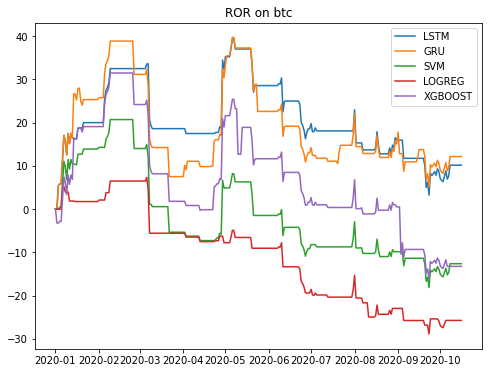

In [ ]:
visualize_ror(df_dict, 'btc')

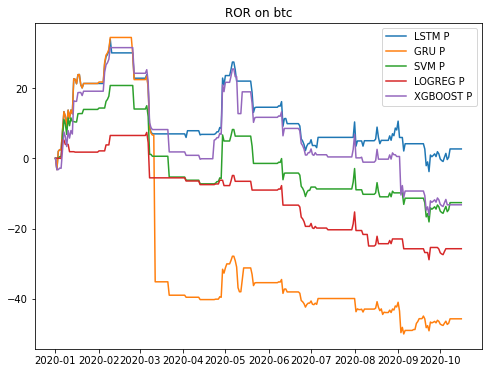

In [ ]:
visualize_ror(df_dict, 'btc',is_purged=True)

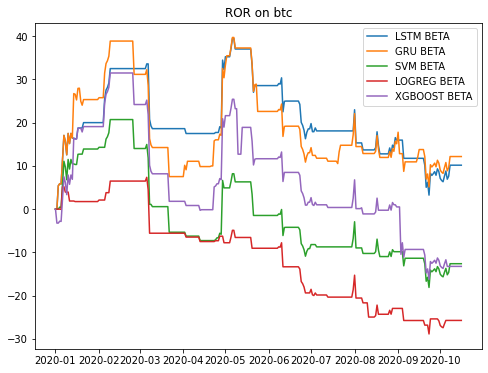

In [ ]:
visualize_ror(df_dict, 'btc', is_beta = True)

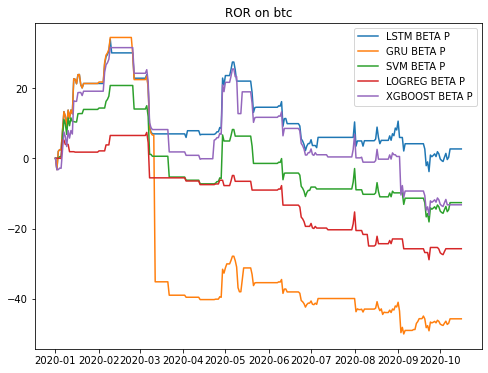

In [ ]:
visualize_ror(df_dict, 'btc', is_beta = True, is_purged = True)

## ETH

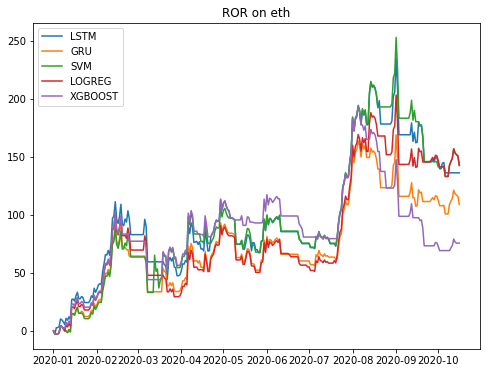

In [ ]:
visualize_ror(df_dict, 'eth')

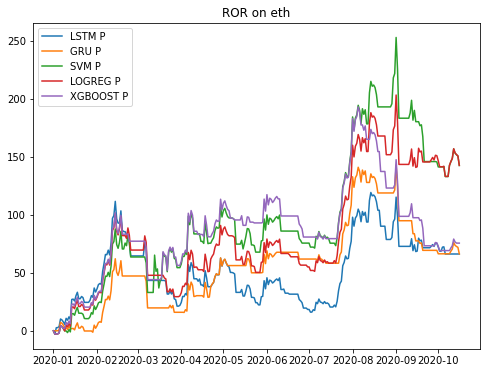

In [ ]:
visualize_ror(df_dict, 'eth',is_purged=True)

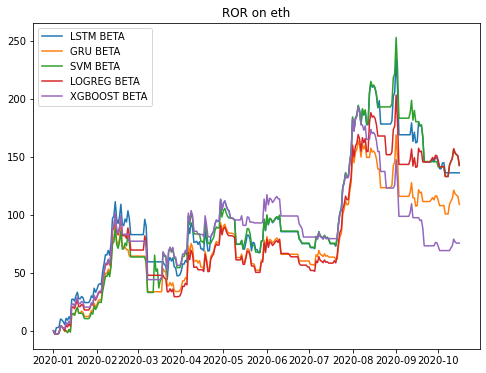

In [ ]:
visualize_ror(df_dict, 'eth', is_beta = True)

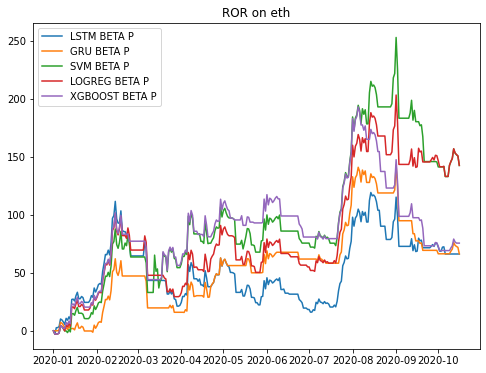

In [ ]:
visualize_ror(df_dict, 'eth', is_beta = True, is_purged = True)

## ADA

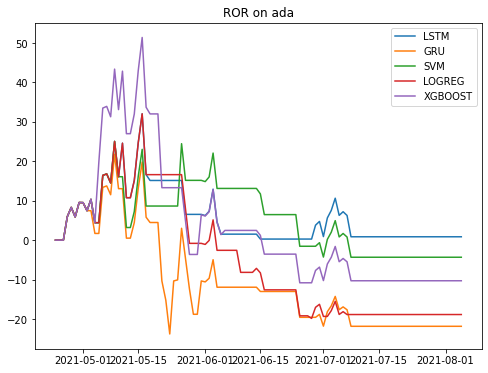

In [ ]:
visualize_ror(df_dict, 'ada')

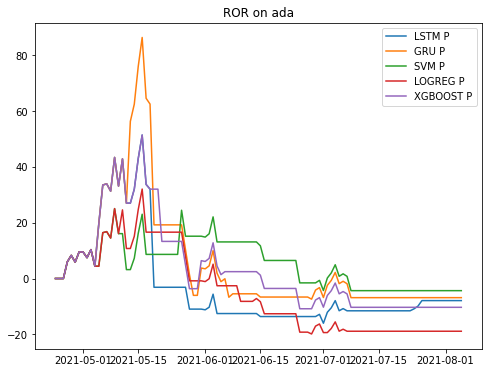

In [ ]:
visualize_ror(df_dict, 'ada',is_purged=True)

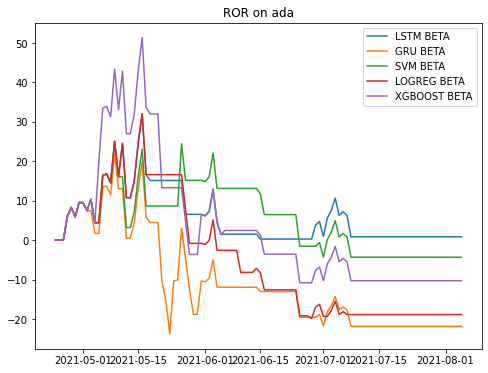

In [ ]:
visualize_ror(df_dict, 'ada', is_beta = True)

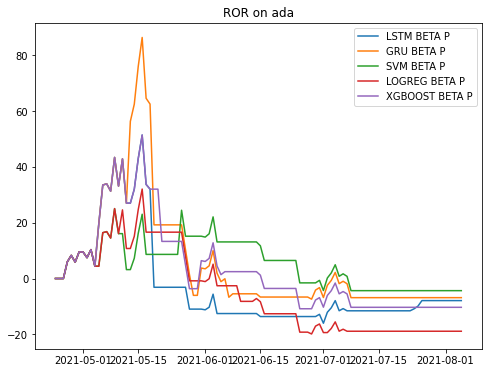

In [ ]:
visualize_ror(df_dict, 'ada', is_beta = True, is_purged = True)

## AAPL

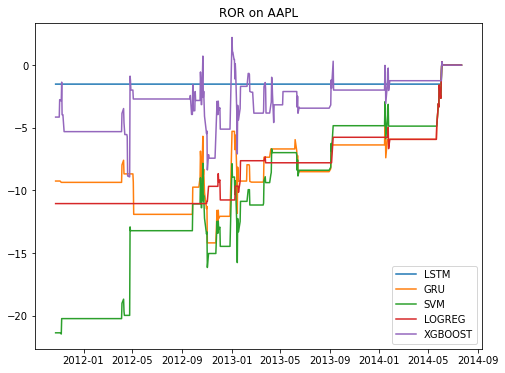

In [67]:
visualize_ror(df_dict, 'AAPL', df_type='sp')

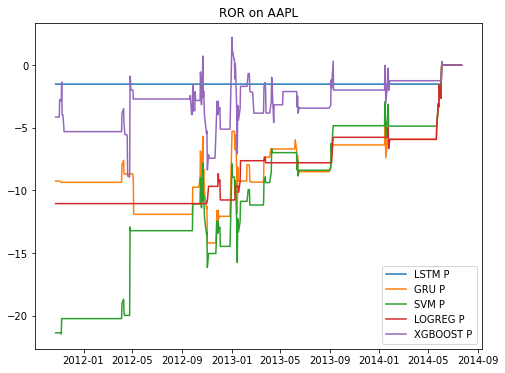

In [68]:
visualize_ror(df_dict, 'AAPL', df_type='sp', is_purged=True)

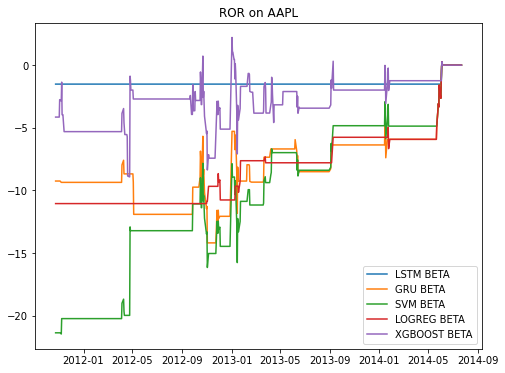

In [69]:
visualize_ror(df_dict, 'AAPL', df_type='sp', is_beta = True)

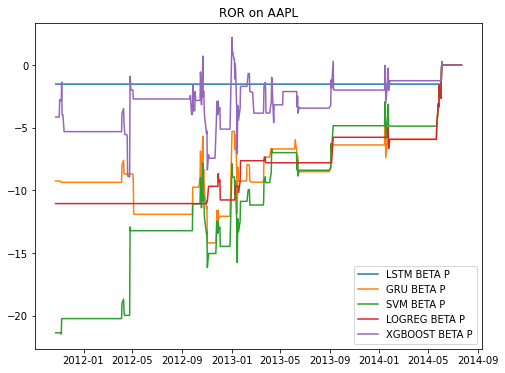

In [70]:
visualize_ror(df_dict, 'AAPL', df_type='sp', is_beta = True, is_purged = True)

## AMD

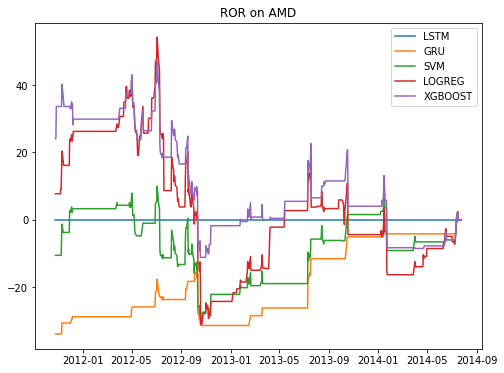

In [72]:
visualize_ror(df_dict, 'AMD', df_type='sp')

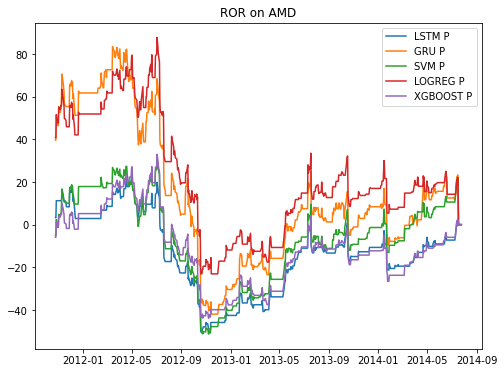

In [73]:
visualize_ror(df_dict, 'AMD', df_type='sp', is_purged=True)

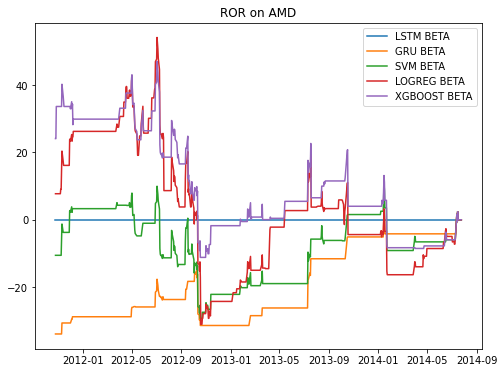

In [74]:
visualize_ror(df_dict, 'AMD', df_type='sp', is_beta = True)

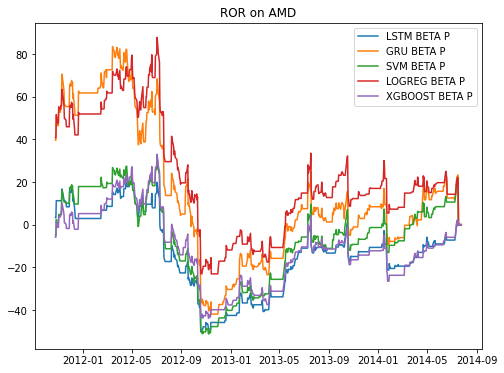

In [75]:
visualize_ror(df_dict, 'AMD', df_type='sp', is_beta = True, is_purged = True)